# Table of Contents
1. [Theoretical foundations](#theoretical-foundations)
1. [Imports](#imports)
1. [prwlr version](#prwlr-version)
1. [Functions definitions](#functions-definitions)
    1. [Miscellaneious](#functions-definitions-miscellaneious)
    1. [Decorators](#functions-definitions-decorators)
    1. [Networks annotation](#functions-networks_annotation)
    1. [Statistics](#functions-definitions-statistics)
    1. [Plotting](#functions-definitions-plotting)
    1. [Pandas styling](#pandas_styling)
    1. [Tests](#functions-definitions-tests)
    1. [Monkey patching](#functions-definitions-monkey-patching)
1. [Data download](#data-download)
    1. [Biogrid physical interactions](#data-download-biogrid-physical-interactions)
1. [KEGG-based data](#kegg-based-data)
    1. [KEGG organisms IDs](#kegg_organisms_ids)
    1. [Reference organisms list](#reference-organisms-list)
    1. [Organisms list for phylogenetic profiles](#organisms-list-for-phylogenetic-profiles)
    1. [KEGG organism-biological name conversion dictionaries](#kegg_organism_biological_name_conversion_dictionaries)
    1. [Binding reference organisms to phylogenetic profiles organisms](#binding_reference_organisms_to_phylogenetic_profiles_organisms)
    1. [KEGG organism ids to full biological names dict](#kegg-organism-ids-to-full-biological-names-dict)
    1. [Phylogenetic profiles](#phylogenetic-profiles)
    1. [Saving profiles to file](#saving_profiles_to_file)
    1. [Checking lengths of the phylogenetic profiles dataframes](#check_the_lengths_of_the_phylogenetic_profiles_dataframes)
    1. [Phylogenetic profiles permutations](#phylogenetic-profiles-permutations)
1. [Biogrid physical interactions](#biogrid-physical-interactions)
    1. [Loading BIOGRID physical interactions networks](#loading_biogrid_physical_interactions_networks)
    1. [Extracting entrez IDs/NCBI gene IDs](#extracting_entrez_ids_ncbi_gene_ids)
    1. [Extracting interaction detection method](#extracting_interaction_detection_method)
    1. [Listing interaction detection methods and number of interactions in general and assigned to each type](#listing_interaction_detection_methods_and_number_of_interactions_in_general_and_assigned_to_each_type)
    1. [Downloading kegg-ncbi ids conversion table](#downloading_the_coversion_table_from_kegg)
    1. [Removing the prefixes in the IDs](#removing_the_prefixes_in_the_ids)
    1. [Joining the biogrid physical interactions table and the kegg conversion table](#joining_the_biogrid_physical_interactions_table_and_the_kegg_conversion_table)
    1. [Merging with phylogenetic profiles](#merging_with_phylogenetic_profiles)
    1. [Listing genes removed by merging with profiles](#listing_genes_removed_by_merging_with_profiles)
    1. [Removing the symmetrical interactions](#removing_the_symmetrical_interactions)
    1. [Saving profilized networks to file](#saving_profilized_networks_to_file)
1. [Interactions count categorized by profiles structure](#physical-interactions-count-categorized-by-profiles-structure)
    1. [Functions definitions](#physical-interactions-count-categorized-by-profiles-structure-functions)
    1. [Calculations](#physical-interactions-count-categorized-by-profiles-structure-calculations)
    1. [Saving calculations results to file](#saving_calculations_results_to_file)
    1. [Result interactive view](#result_interactive_view)
    1. [Tabular view](#tabular_view)
    1. [Network view](#network_view)
1. [Issues](#issues)

<a class='anchor' id='theoretical-foundations'></a>
# Theoretical foundations

1. The key concept is to find out if there is any enrichment of interactions betweeen genes/proteins of particular phylogenetic profiles

**Procedure**

1. Interaction Networks Preparation

    1. All of the interaction networks assigned to an organism, available at [Biogrid](http://thebiogrid.org) are downloaded.

    1. A proper (clean from prefixes and similar) gene/protein/ORF IDs are extracted from the interaction networks

    1. A proper IDs conversion table is downloaded using the official [KEGG API](https://kegg.jp/kegg/rest/keggapi.html).

    1. Using the IDs conversion KEGG table, the gene/protein/ORF IDs in the interaction networks are converted to the ORF IDs recognized by KEGG.

1. Phylogenetic Profiles Preparation

    1. The list of organism for constructing the phylogenetic profiles is defined. It contains taxa from bacteria, archea and eukarya domains of life.
    
    1. For each of the interaction networks, if an organism for which the network is processed is present in the list for constructing the phylogenetic profile, then such an organism is **removed from the list**. Otherwise, the network would not posses any flat/empty/minuses-only profiles.
    
    1. The profiles are constructed allowing for the KOs duplications. It means that multiple genes from **the same organism** can belong to the same KO. In the original notebook this was not allowed, hence probably the small number of interactions that was left after merging with the profiles - the number of profilized ORFs was not high.



1. Phylogenetic profiles are constructed for each of the interactions networks published by [Biogrid](http://thebiogrid.org) and assigned to an organism.

### Notes

- If an organism appears in the list of analyzed interactions network should it also be present in the phylogenetic profiles?

- Is it fine some of the profiles pairs present in the native networks are not found in any permutation? The permutations are performed for each of the profile independently

<a class='anchor' id='imports'></a>
# Imports

In [1]:
from functools import wraps

import datetime

from IPython.display import Image, HTML
import ipywidgets as widgets

import gc
from glob import glob
import re
from collections import defaultdict
import tempfile
import random
from functools import reduce
from functools import partial
from itertools import product
import inspect
import requests

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

import pandas as pd
import numpy as np

import prwlr

<a class='anchor' id='prwlr-version'></a>
# prwlr version

Since this is the version in which the duplicated KOs are **NOT** dropped and the feature is experimental. ```prwlr``` is installed from a git branch with pip in the develop mode

In [2]:
prwlr.__version__

'0.0.3'

<a class="anchor" id='functions-definitions'></a>
# Functions definitions

<a class=anchor id=functions-definitions-miscellaneious></a>
## Miscellaneious

In [3]:
def mark_lower(
    d:dict,
    threshold:int,
    background_color:str='red'
) -> pd.DataFrame:
    """
    Apply len function on values from dict <d>.
    Group results in pandas.DataFrame with conditional
    formatting. Mark values lower than <threshold> with
    <background_color>.
    
    Returns
    -------
        pandas.DataFrame
    """
    d_lengths = {
        k: len(d[k])
        for k in tuple(d.keys())
    }

    d_lengths_df = pd.DataFrame(
        {'length': tuple(d_lengths.values())},
        index=d_lengths.keys(),
    )
    return d_lengths_df.style.applymap(lambda x: f'background-color: {background_color}' if x < threshold else '')
# Visual unittest equivalent
t = 1
c = 'red'
_test_d = {
    'a': list('foobar'),
    'b': list('foobaz'),
    'c': [],
    'd': '',
    'e': pd.DataFrame({'a': range(10), 'b': range(10, 20)}),
    'f': pd.Series({'a': range(10)}),
}
mark_lower(_test_d, t, c)

,length
a,6
b,6
c,0
d,0
e,10
f,1


In [4]:
def mark_lower_group(
    dfs:pd.DataFrame,
    group_col:str,
    threshold:int,
    background_color:str='red',
) -> pd.DataFrame:
    """
    Group pandas.DataFrames from <dfs> by a single
    column and count rows. Group results in pandas.DataFrame with
    conditional formatting. The column names are created after values found.
    The index is created after <dfs> keys. Values lower than <threshold> are
    marked with <background_color>.
    """
    sizes = {
        k: v.groupby(by=[group_col]).size()
        for k, v in dfs.items()
    }

    sizes_df = pd.concat(
        tuple(
            pd.DataFrame({k: v}).T
            for k, v in sizes.items()
        ),
    ).fillna(0).style.applymap(lambda x: 'background-color: red' if x < 1 else '')

    return sizes_df
# Visual unittest equivalent
_test_dfs = {
    k: pd.DataFrame(
        {
            'COLUMN_1': [['one', 'two', 'three'][random.randrange(0, i + 1)] for i in range(0, 3)],
        }
    )
    for k in ('foo', 'bar', 'baz')
}
mark_lower_group(dfs=_test_dfs, group_col='COLUMN_1', threshold=1)

/home/dizak/miniconda3/envs/prwlr_UPD126/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,one,three,two
foo,1,1,1
bar,3,0,0
baz,3,0,0


In [5]:
class listx(list):
    """
    Class for extendending standard list
    with custom methods.
    """
    def __init__(
        self,
        li,
    ):
        self._li = li
    
    def __repr__(self):
        return str(self._li)
    
    def without(
        self,
        element,
    ):
        """
        Return list without an <element>.
        """
        return [_ for _ in self._li if _ != element]

In [6]:
def get_most_frequent_profiles_pair(
    df,
    min_number=5,
    how_many=10,
    PROF_Q_col='PROF_Q',
    PROF_A_col='PROF_A',
    number_col='inter_number',
    perc_col='inter_perc',
):
    return df[(df[number_col] > min_number)].sort_values(by=[perc_col], ascending=False)[[PROF_Q_col, PROF_A_col]].drop_duplicates().iloc[:how_many].reset_index(drop=True)

In [7]:
def save_profiles(
    dataframe,
    filename,
    **kwargs
):
    """
    Writes pandas.Series with prwlr.profiles.Profile objects to CSV file.
    Together with prwlr.core.read_profiles provides a convenient way of
    saving/reading-in prwlr.profiles.Profile objects to/from a flat text file.

    Parameters
    -------
    Filename: str, path
        CSV file name.
    """
    pd.DataFrame(
        {
            prwlr.Columns.ORF_ID: dataframe[prwlr.Columns.ORF_ID],
            prwlr.Columns.REF: dataframe[prwlr.Columns.PROF].apply(
                lambda x: x.reference,
            ).str.join(prwlr.Columns.STR_SEP),
            prwlr.Columns.QRY: dataframe[prwlr.Columns.PROF].apply(
                lambda x: x.query,
            ).str.join(prwlr.Columns.STR_SEP),
        },
    ).to_csv(filename, **kwargs)

In [8]:
def read_profiles(
    filename,
    **kwargs
):
    """
    Returns pandas.Series with prwlr.profiles.Profile objects from CSV file.
    Together with prwlr.core.save_profiles provides a convenient way of
    saving/reading-in prwlr.profiles.Profile objects to/from a flat text file.

    Parameters
    -------
    filename: str, path
        CSV file name.

    Returns
    ------
    pandas.Series
    """
    ref_qry_df = pd.read_csv(filename, **kwargs)
    ref_qry_df[prwlr.Columns.REF_SPLIT] = ref_qry_df[prwlr.Columns.REF].str.split(prwlr.Columns.STR_SEP)
    ref_qry_df[prwlr.Columns.QRY_SPLIT] = ref_qry_df[prwlr.Columns.QRY].str.split(prwlr.Columns.STR_SEP)
    ref_qry_df[prwlr.Columns.PROF] = ref_qry_df[[prwlr.Columns.REF_SPLIT, prwlr.Columns.QRY_SPLIT]].apply(
        lambda x: prwlr.profiles.Profile(
            reference=x[prwlr.Columns.REF_SPLIT],
            query=x[prwlr.Columns.QRY_SPLIT],
        ),
        axis=1,
    )
    return ref_qry_df[[prwlr.Columns.ORF_ID, prwlr.Columns.PROF]]

<a class="anchor" id='functions-definitions-decorators'></a>
## Decorators

In [9]:
def sort_and_reindex(sort_by):
    """
    Sort and reindex pandas.DataFrame.
    
    Parameters
    -------
    sort_by: list or tuple of str
        Columns names to sort by.
        
    Returns
    -------
        pandas.DataFrame
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            return function(*args, **kwargs).sort_values(by=sort_by).reset_index(drop=True)
        return wrapper
    return decorator

In [10]:
def concatenate_dfs_from_list_vertically(function):
    """
    Concatenates an iterable of pandas.DataFrames vertically into
    single pandas.DataFrame.
    
    Returns
    -------
        pandas.DataFrame
    """
    @wraps(function)
    def wrapper(*args):
        output = function(*args)
        return reduce(
            lambda df1, df2: pd.concat(
                [df1, df2],
            ),
            output,
        ).reset_index(drop=True)
    return wrapper

In [11]:
def enumerate_dfs_in_iterable(function):
    """
    Adds a column with subsequent number to each pandas.DataFrame
    in the iterable. Starts with 1.
    
    Yields
    -------
        Iterable of pandas.DataFrames
    """
    @wraps(function)
    def wrapper(*args):
        output = function(*args)
        for number, dataframe in enumerate(output):
            dataframe['permutation'] = number + 1
            yield dataframe
    return wrapper

In [12]:
def normalize_to_df_size(
    num_cols:dict={
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
    }
):
    """
    Normalize to any number passed as argument.
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            wrapped = function(*args, **kwargs)
            wrapped[num_cols['sum']] = wrapped[num_cols['number']].sum()
            wrapped[num_cols['percent']] = wrapped[num_cols['number']] / wrapped[num_cols['sum']]
            return wrapped
        return wrapper
    return decorator

def normalize_to_df_size_iter(
    num_cols:dict={
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
    }
):
    """
    Normalize to any number passed as argument.
    """
    def decorator(function):
        @normalize_to_df_size(num_cols=num_cols)
        @wraps(function)
        def _f(i):
            return i
        def wrapper(*args, **kwargs):
            for wrapped in function(*args, **kwargs):
                yield _f(wrapped)
        return wrapper
    return decorator

In [13]:
def sum_profiles_two_sides(
    profs_cols:list=[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A],
    num_cols:dict={
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
    }
):
    """
    Sums-up interactions number for profiles
    assignegned symmetricaly inside the interaction.
    It does NOT remove the interaction symmetry.
    
    Parameters
    -------
    profs_cols: list, default <[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A]>
        Column names of the query and array profiles.
    num_cols: dict, default <{
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
        }>
        Columns names of the numerical values.
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            # Function for passing number of interaction for one component
            # as sum. Otherwise the number interactions for a pair of profiles
            # identical in both ways would be doubled.
            def f(row):
                if row['PROFS_IDENTICAL']:
                    row[num_cols['number'] + '_xy'] = row[num_cols['number'] + '_x']
                    return row
                return row
            wrapped = function(*args, **kwargs)
            # Merge the grouped dataframe with itself but profiles columns
            # switched places. Make sure to merge outer and fill NaNs with zeros
            wrapped_two_sides = pd.merge(
                left=wrapped,
                right=wrapped.rename(columns={
                    profs_cols[0]: profs_cols[1],
                    profs_cols[1]: profs_cols[0],
                }),
                on=profs_cols,
                how='outer',
            ).fillna(0)
            # Sum-up numeric values and output
            wrapped_two_sides[num_cols['number'] + '_xy'] = (
                wrapped_two_sides[num_cols['number'] + '_x'] +
                wrapped_two_sides[num_cols['number'] + '_y']
            )
            # Find and mark the profiles that are identical in both ways
            wrapped_two_sides['PROFS_IDENTICAL'] = (
                wrapped_two_sides[profs_cols[0]] ==
                wrapped_two_sides[profs_cols[1]]
            )
            # Find and mark identical pairs of profiles *not idenctical profiles inside the pair*
            # but switched places.
            wrapped_two_sides['PROFS_SORTED'] = wrapped_two_sides.apply(
                lambda x: '|'.join(sorted((x[profs_cols[0]].to_string(), x[profs_cols[1]].to_string()))),
                axis=1,
            )
            # Remove the duplicates of identical pairs of profiles. This prevents inflating
            # the number of interactions after previous sum-up operations.
            wrapped_two_sides.drop_duplicates(subset=['PROFS_SORTED'], inplace=True)
            # If the profiles in pair are indentical both ways just pass the value
            wrapped_two_sides_same_divided = wrapped_two_sides.apply(
                f,
                axis=1,
            )
            # Rename the sum-up column as the initial numeric values column
            # Two columns holding sums are remnant after merge. These columns are
            # identical. One of them is renamed to the original name
            wrapped_two_sides_same_divided.rename(
                columns={
                    num_cols['number'] + '_xy': num_cols['number'],
                    num_cols['sum'] + '_x': num_cols['sum'],
                },
                inplace=True,
            )
            # Drop the intermediate columns with values of identical profiles pairs and numeric values.
            # One of the doubled column with sum **the remnant after merge** is dropped as the other was
            # renamed to the original name above.
            wrapped_two_sides_same_divided.drop(
                columns=[
                    num_cols['number'] + '_x',
                    num_cols['number'] + '_y',
                    num_cols['sum'] + '_y',
                    num_cols['percent'] + '_x',
                    num_cols['percent'] + '_y',
                    'PROFS_IDENTICAL',
                    'PROFS_SORTED',
                ],
                inplace=True,
            )
            # Re-calculate the relative numeric values
            wrapped_two_sides_same_divided['inter_perc'] = (
                wrapped_two_sides_same_divided['inter_number'] /
                wrapped_two_sides_same_divided['inter_sum']
            )
            return wrapped_two_sides_same_divided
        return wrapper
    return decorator
def sum_profiles_two_sides_iter(*top_args, **top_kwargs):
    """
    sum_profiles_two_sides suitable for iteration
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            @sum_profiles_two_sides(*top_args, **top_kwargs)
            def _f(i):
                return i
            for wrapped in function(*args, **kwargs):
                yield _f(wrapped)
        return wrapper
    return decorator

In [14]:
def merge_with_sliding_window_fill_nans_per_element(window):
    """
    Merge each pandas.DataFrame from iterable with seprately prepared
    pandas.DataFrame holding all desired *not necessarily all possible*
    combinations of attributes of interest called *window*. If the co-occurence is
    present only in the *window* - result with 0s.
    
    Parameters
    -------
    window: pandas.DaraFrame
    
    Yields
    -------
        Iterable of pandas.DataFrames.
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            for _ in function(*args, **kwargs):
                yield pd.merge(
                    left=window,
                    right=_,
                    how='left',
                ).fillna(0)
        return wrapper
    return decorator

In [15]:
def group_dfs_in_list_count_size(group_cols, output_col_name='inter_number'):
    """
    For each pandas.DataFrame in the iterable group by
    given attributes list and count number of rows with
    pandas.DataFrame.size method.
    
    Parameters
    -------
    group_cols: list
        Attributes to group based on which pandas.DataFrame is grouped.
    output_col_name: str, default: <inter_number>
        Name of column holding the result numbers.
    
    Yields
    -------
        Iterable of pandas.DataFrames
    """
    def decorator(function):
        @wraps(function)
        def wrapper(*args):
            output = function(*args)
            for _ in output:
                yield pd.DataFrame(
                    _.groupby(
                        by=group_cols,
                    ).size(),
                        columns=[output_col_name],
            ).reset_index()
        return wrapper
    return decorator

<a class=anchor id=functions-networks_annotation></a>
## Networks annotation

In [198]:
def assign_taxonomy(
    row,
    archea,
    bacteria,
    eukaryots,
):
    """
    Assign the taxonomical domain depending on whether
    the organisms passed are in present in
    the phylogenetic profiles EXLUSIVELY. In case of ambiguity
    it is assigned as <mixed>.
    
    Parameters
    -------
    row: pandas.DataFrame row
        Suitable for pandas.DataFrame.apply method.
    
    Returns
    -------
    str, abbreviated name of the domain
        arch, bact, eukar, S_cer, mixed
    """
    if prwlr.utils.isiniterable(
        archea,
        [IDs_names[_] for _ in row.get_present()],
        all_present=False,
        ) and prwlr.utils.isiniterable(
            bacteria + eukaryots,
            [IDs_names[_] for _ in row.get_absent()],
            all_present=True,
        ):
        return 'arch'
    elif prwlr.utils.isiniterable(
        bacteria,
        [IDs_names[_] for _ in row.get_present()],
        all_present=False,
    ) and prwlr.utils.isiniterable(
        archea + eukaryots,
        [IDs_names[_] for _ in row.get_absent()],
        all_present=True,
    ):
        return 'bact'
    elif prwlr.utils.isiniterable(
        eukaryots,
        [IDs_names[_] for _ in row.get_present()],
        all_present=False,
    ) and prwlr.utils.isiniterable(
        archea + bacteria,
        [IDs_names[_] for _ in row.get_absent()],
        all_present=True,
    ):
        return 'eukar'
    elif prwlr.utils.isiniterable(
        archea + bacteria + eukaryots,
        [IDs_names[_] for _ in row.get_present()],
        all_present=True,
    ):
        return 'all'
    else:
        return 'mixed'

<a class=anchor id=functions-definitions-statistics></a>
## Statistics

In [16]:
def calc_p_val(
    native_df,
    permuted_df,
    nominal_cols:list,
    num_cols:dict={
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
    },
    suffixes:list=['_nat', '_per'],
    native_higher_col:str='native_higher',
    native_lower_col:str='native_lower',
    perm_num_col:str='per_number',
    total_perm_num:int=1000
):
    """
    Calculate two-tailed p-values out of results of permutation test.
    
    Parameters
    -------
    native_df: pandas.DataFrame
        Native values compared to the permuted results.
    permuted_df: pandas.DataFrame
        Permuted values compared to the native ones.
    nominal_cols: list
        Columns names holding the nominal variables compared between native and
        permuted dataframes.
    num_cols: list, default <{
        'number': 'inter_number',
        'sum': 'inter_sum',
        'percent': 'inter_perc',
    }>
        Columns names holding the ratio numerical ratio variables compared
        between native and permuted dataframes.
    suffixes: list, default <['_nat', '_per']>
        Suffixes for columns names after merging native and permuted
        dataframes.
    native_higher_col: str, default <native_higher>
        Column name of boolean variable telling if the native value for
        observation is greater than permuted one.
    native_lower_col: str, default <native_lower>
        Column name of boolean variable telling if the native value for
        observation is greater than permuted one.
    perm_num: str, default <perm_number>
        Column name of ratio variable holding p-values. The p-value is
        calculated as follows:
        1 - <native_higher_col> / total_perm_num
        1 - <native_lower_col> / total_perm_num
    
    Returns
    -------
        pandas.DataFrame
    """
    native_permuted = pd.merge(
        left=native_df,
        right=permuted_df,
        on=nominal_cols,
        suffixes=suffixes,
    )
    native_permuted[native_higher_col] = (
        native_permuted[num_cols['percent'] + suffixes[0]] >
        native_permuted[num_cols['percent'] + suffixes[1]]
    )
    native_permuted[native_lower_col] = (
        native_permuted[num_cols['percent'] + suffixes[0]] <
        native_permuted[num_cols['percent'] + suffixes[1]]
    )
    native_permuted_grpd = native_permuted.groupby(
        by=nominal_cols +
        [native_higher_col] +
        [native_lower_col]
    ).size().reset_index().rename(columns={0: perm_num_col})
    native_permuted_grpd['p-value'] = (
        1 - native_permuted_grpd[perm_num_col] / total_perm_num
    )
    return native_permuted_grpd

<a class="anchor" id='functions-definitions-plotting'></a>
## Plotting

In [17]:
def draw_two_panels_hue(
    left_native,
    right_native,
    left_permuted,
    right_permuted,
    title:str,
    left_native_color=None,
    right_native_color=None,
    left_permuted_color=None,
    right_permuted_color=None,
    left_title:str=None,
    right_title:str=None,
    left_significant_cols:list=None,
    right_significant_cols:list=None,
    y:str='inter_perc',
    x:str='GIS_binned',
    left_hue:str='PROF_SIMILAR',
    right_hue:str='PATH_SIMILAR',
    significance_sign:str='*',
    significance_position:str=-0.1,
    context:str='notebook',
    context_rc:dict=None,
    figure_size:tuple=(32, 12),
    figure_filename:str=None,
    function=None,
):
    """
    Draw two-panels plot with categories on the x-axis and hue for
    additional discrimination for nominal variables. It is meant to be used
    for line-and-boxplot which compares the native and permuted networks.
    
    left_native: pandas.DataFrame
        Native network to be shown on the left panel.
    right_native: pandas.DataFrame
        Native network to be shown on the rigth panel.
    left_permuted: pandas.DataFrame
        Permuted network to be shown on the left panel.
    right_permuted: pandas.DataFrame
        Permuted network to be shown on the rigth panel.
    title: str
        The main title for the whole plot.
    left_native_color: str, default <None>
        Color of the native network on the left panel. Color from the
        default pallete is taken if <None>.
    right_native_color: str, default <None>
        Color of the native network on the right panel. Color from the
        default pallete is taken if <None>.
    left_permuted_color: str, default <None>
        Color of the permuted network on the left panel. Color from the
        default pallete is taken if <None>.
    right_permuted_color: str, default <None>
        Color of the permuted network on the right panel. Color from the
        default pallete is taken if <None>.
    left_title: str, default <None>
        Title for the left panel. No title is added if <None>.
    right_title: str, default <None>
        Title for the right panel. No title is added if <None>.
    left_significant_cols: list of int, default <None>
        Columns numbers to which the <significance_sign> is added at
        <significance_position> on the left panel.
    right_significant_cols: list of int, default <None>
        Columns numbers to which the <significance_sign> is added at
        <significance_position> on the right panel.
    y: str, default <inter_perc>
        Column name with values to plot on the y-axis.
    x: str, default <GIS_binned>
        Column name with values to plot on the x-axis.
    left_hue: str, default <PROF_SIMILAR>
        Column name with nominal variables used for colorful
        discrimination on the left panel.
    right_hue: str, default <PATH_SIMILAR>
        Column name with nominal variables used for colorful
        discrimination on the right panel.
    context: str, default <notebook>
        Context global setting that seaborn uses for the plot's
        esthetics.
    context_rc: dict, default <None>
        Additional parameters for the plot esthetics passed through seaborn
        to matplotlib.
    figure_size: tuple of int, default <(32, 12)>
        Size of the final plot.
    figure_filename: str, default <None>
        Path to save the plot to file. Nothing is saved if None.
    """
    # Prepare subplots with two columns and single row. Meant to be repeated for each preselection
    if right_native is None and right_permuted is None:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
        left_axes = axes
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figure_size)
        left_axes = axes[0]
    # Set figures' context
    sns.set_context(context, rc=context_rc)
    # Set common title
    plt.suptitle(title)
    # Native networks
    if left_native is not None and len(left_native) > 0:
        plot = sns.pointplot(
            data=left_native,
            y=y,
            x=x,
            color=left_native_color,
            hue=left_hue,
            ax=left_axes,
        ).set_title(left_title)
        if left_significant_cols is not None and len(left_significant_cols) > 0:
            for _ in left_significant_cols:
                axes[0].text(_, significance_position, significance_sign)
    if right_native is not None and len(right_native) > 0:
        plot = sns.pointplot(
            data=right_native,
            y=y,
            x=x,
            color=right_native_color,
            hue=right_hue,
            ax=axes[1],
        ).set_title(right_title)
        if right_significant_cols is not None and len(right_significant_cols) > 0:
            for _ in right_significant_cols:
                axes[1].text(_, significance_position, significance_sign)
    # Permuted networks
    if left_permuted is not None and len(left_permuted) > 0:
        plot = sns.boxplot(
            data=left_permuted,
            y=y,
            x=x,
            color=left_permuted_color,
            hue=left_hue,
            ax=left_axes,
        ).set_title(left_title)
    if right_permuted is not None and len(right_permuted) > 0:
        plot = sns.boxplot(
            data=right_permuted,
            y=y,
            x=x,
            color=right_permuted_color,
            hue=right_hue,
            ax=axes[1],
        ).set_title(right_title)
    
    if function: function()
    if figure_filename:
        fig = plot.get_figure()
        if function: function()
        fig.savefig(figure_filename, format=figure_filename.split('.')[-1], bbox_inches='tight')

In [18]:
def render_display_figures_grid(
    title:str,
    figures_path:str,
    figures_filename_pattern:str,
    cols_number:int=2,
    figures_limit:int=20,
) -> str:
    """
    Display graphics (meant for series of plots) using
    CSS-grid.
    """
    html_template = """
        <style>
            .debug-border:hover {{
                border: solid red 1px;
            }}
            .center {{
                text-align: center;
            }}
            .zoom-on-hover:hover {{
                transform: scale(2);
            }}
            .grid-container {{
                display: grid;
                grid-template-columns: {};
            }}
        </style>
        <h1 class="center">{}</h1>
        <div class=grid-container>{}</div>
    """
    figures = glob(f'{figures_path}/{figures_filename_pattern}')
    if len(figures) > figures_limit:
        title = f'{title} - too many figures to display ({len(figures)}). Showing only {figures_limit}'
        figures = figures[:figures_limit]
    figures = ''.join((
        f'<div><img class="zoom-on-hover" src="{i}" alt=""></div>'
        for i in figures
    ))
    return html_template.format(
        cols_number * 'auto ',
        title,
        figures,
    )

<a class=anchor id=pandas_styling></a>
## Pandas styling

In [763]:
def styling_highlight_significant(
    s,
    significance:float=0.01,
    significant_color:str='green',
    insignificant_color:str='red',
):
    """
    Set background color depending on level of significance.
    """
    if s.dtype == 'float64':
        return [
            f'background-color: {significant_color}'
            if i < significance
            else f'background-color: {insignificant_color}'
            for i in s
        ]
    return ['background-color: ' for i in s]

In [764]:
def styling_highlight_bool(
    s,
    true_color:str='green',
    false_color:str='red',
):
    """
    Set background color depending on whether value in column is True.
    """
    if s.dtype == 'bool':
        return [
            f'background-color: {true_color}'
            if i
            else f'background-color: {false_color}'
            for i in s
        ]
    return ['background-color: ' for i in s]

<a class=anchor id=functions-definitions-tests></a>
## Tests

Functions for testing whether the results contain technical errors.

In [19]:
def test_sliding_window_size(
    df,
    window_size:int=10,
    perm_col:str='permutation',
):
    """
    Test if the window size in the permuted network is
    the same of each permutation.
    
    Parametrs
    -------
    df: pandas.DataFrame
        Permuted network to test.
    window_size: int, default <10>
        Length of the pandas.DataFrame part that represents
        the sliding window.
    perm_col: str, default <permutation>
        Name of column with permutation values in the
        permuted network.
    perm_start: int, default <1>
        Number designating the first permutation.
    
    """
    size_per_perm = (
        len(df[(df[perm_col] == i)])
        for i in df[perm_col].drop_duplicates()
    )
    first_perm_size = next(size_per_perm)
    assert all(i == window_size for i in size_per_perm)

In [20]:
def test_relative_n_per_perm(
    df,
    perm_col:str='permutation',
    inter_perc_col:str='inter_perc',
    perm_start:int=1,
    perm_n:int=1000,
    tolerance:tuple=(0.99, 1.01),
):
    """
    Test if the relative number of interactions adds-up to 1 (or 100)
    for each permutation. Because of the floating-point errors there
    must be some tolerance for the values in the test. In this case
    it is 0.99 < value < 1.01
    
    Parameters
    -------
    df: pandas.DataFrame
        Permuted network to test.
    perm_col: str, default <permutation>
        Name of column with permutation values in the
        permuted network.
    perm_start: int, default <1>
        Number designating the first permutation.
    tolerance: two int tuple, default <(0.99, 1.01)>
    """
    sums_per_perm = (
        df[(df[perm_col] == i)][inter_perc_col].sum()
        for i in range(perm_start, perm_n + 1)
    )
    assert all((tolerance[0] < i < tolerance[1]) for i in sums_per_perm)

<a class=anchor id=functions-definitions-monkey-patching></a>
## Monkey patching

Do **NOT** save modified source code under the same name!

```prwlr.databases.parse_organism_info``` which does not throw an error after KO ```pandas.Series``` comparison. **This is risky and should no stay in the final version!**

In [21]:
source_merge_sga_profiles = inspect.getsource(prwlr.merge_sga_profiles)
print(source_merge_sga_profiles)

new_source_merge_sga_profiles = source_merge_sga_profiles.replace(
    'def merge_sga_profiles(\n',
    'from prwlr import databases as _databases\nimport pandas as _pd\n\n\ndef merge_sga_profiles_no_dropna(\n',
).replace(
    '    merged.dropna(inplace=True)\n',
    '',
)
print(new_source_merge_sga_profiles)

exec(new_source_merge_sga_profiles, prwlr.__dict__)

def merge_sga_profiles(
    sga,
    profiles
):
    """
    Returns Genetic Interaction Network from the Costanzo's SGA experiment with
    Phylogenetic Profiles.
    """
    merged = _pd.merge(
        left=sga,
        right=profiles,
        left_on=_databases.Columns.ORF_Q,
        right_on=_databases.Columns.ORF_ID,
        how="left",
    ).merge(
        right=profiles,
        left_on=_databases.Columns.ORF_A,
        right_on=_databases.Columns.ORF_ID,
        how="left",
        suffixes=(
            _databases.Columns.QUERY_SUF,
            _databases.Columns.ARRAY_SUF,
        )
    )
    merged.drop(
        columns=[
            _databases.Columns.ORF_ID_Q,
            _databases.Columns.ORF_ID_A,
        ],
        axis=1,
        inplace=True,
    )
    merged.dropna(inplace=True)
    merged.reset_index(
        drop=True,
        inplace=True,
    )
    return merged

from prwlr import databases as _databases
import pandas as _pd


def merge_sga_profiles_no_dropna(
 

In [22]:
source_get_KOs_db_X_ref = inspect.getsource(prwlr.apis.KEGG_API.get_KOs_db_X_ref)
print(source_get_KOs_db_X_ref)

    def get_KOs_db_X_ref(self,
                         filename,
                         target_db='genes',
                         skip_dwnld=False,
                         strip_prefix=True,
                         squeeze=True,
                         sep="\t",
                         threads=1):
        """
        Get desired KEGG's database entries linked with KEGG Orthology Group.
        Data are downloaded to a local file and then made into pandas.DataFrame.
        File can be reused.

        Parameters
        -------
        filename: str
            Name of the file to download.
        targed_db: str
            Key for KEGG_API.databases of desired database.
        skip_dwnld: bool, default <False>
            Read already downloaded file if <True>
        squeeze: bool, default <True>
            Compress list of the organisms to list for each KEGG Orthology
            Group
        sep: str, default: <\t>
            Delimiter to use.
        threads: int, de

<a class=anchor id=data-download></a>
# Data download

<a class=anchor id=data-download-biogrid-physical-interactions></a>
## Biogrid physical interactions

In [23]:
%%bash

wget --directory-prefix ./presentation-main-data/biogrid https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.175/BIOGRID-ORGANISM-3.5.175.mitab.zip

unzip ./presentation-main-data/biogrid/BIOGRID-ORGANISM-3.5.175.mitab.zip -d ./presentation-main-data/biogrid/

Archive:  ./presentation-main-data/biogrid/BIOGRID-ORGANISM-3.5.175.mitab.zip


--2019-10-07 13:14:30--  https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.175/BIOGRID-ORGANISM-3.5.175.mitab.zip
Resolving downloads.thebiogrid.org (downloads.thebiogrid.org)... 173.255.198.187
Connecting to downloads.thebiogrid.org (downloads.thebiogrid.org)|173.255.198.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/download]
Saving to: ‘./presentation-main-data/biogrid/BIOGRID-ORGANISM-3.5.175.mitab.zip.1’

     0K .......... .......... .......... .......... ..........  348K
    50K .......... .......... .......... .......... ..........  265K
   100K .......... .......... .......... .......... ..........  454K
   150K .......... .......... .......... .......... .......... 87.9M
   200K .......... .......... .......... .......... ..........  340K
   250K .......... .......... .......... .......... .......... 35.0M
   300K .......... .......... .......... .......... ..........  339K
   350K .......... 

CalledProcessError: Command 'b'\nwget --directory-prefix ./presentation-main-data/biogrid https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.175/BIOGRID-ORGANISM-3.5.175.mitab.zip\n\nunzip ./presentation-main-data/biogrid/BIOGRID-ORGANISM-3.5.175.mitab.zip -d ./presentation-main-data/biogrid/\n'' returned non-zero exit status 1.

<a class="anchor" id='kegg-based-data'></a>
# KEGG-based data

<a class=anchor id=kegg_organisms_ids></a>
## KEGG organisms IDs

Get the KEGG-ORG-ID conversion table. It is used in [Download KEGG-NCBI IDs Conversion Table](#downloading_the_coversion_table_from_kegg) section

In [25]:
kegg_api = prwlr.apis.KEGG_API()

In [26]:
tmp = tempfile.NamedTemporaryFile(delete=True)
kegg_api.get_organisms_ids(tmp.name)

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


<a class=anchor id=reference-organisms-list></a>
## Reference organisms list

Organisms list from which the interaction networks are derived.

The list is constructed from the files (interaction networks) downloaded from the [Biogrid](http://thebiogrid.org).

In [27]:
ntwrk_file_prefix = 'BIOGRID-ORGANISM-'
directory_prefix = './presentation-main-data/biogrid'

_ref_biogrid_orgs = frozenset(
    ' '.join(i.split(
        ntwrk_file_prefix,
    )[1].split(
        '_',
    )[:2]).split(
        '-',
    )[0]
    for i in 
    glob(f'{directory_prefix}/{ntwrk_file_prefix}*')
)

ref_biogrid_orgs = frozenset(
    i
    for i in _ref_biogrid_orgs
    if i.replace(' ', '').isalpha()
)

for i in ref_biogrid_orgs: print(i, end=', ')

Oryza sativa, Pan troglodytes, Mus musculus, Solanum lycopersicum, Emericella nidulans, Simian Virus, Plasmodium falciparum, Apis mellifera, Caenorhabditis elegans, Homo sapiens, Equus caballus, Human Immunodeficiency, Zea mays, Leishmania major, Ustilago maydis, Neurospora crassa, Nicotiana tomentosiformis, Cricetulus griseus, Xenopus laevis, Mycobacterium tuberculosis, Human Herpesvirus, Arabidopsis thaliana, Dictyostelium discoideum, Candida albicans, Sus scrofa, Hepatitus C, Vaccinia Virus, Glycine max, Drosophila melanogaster, Solanum tuberosum, Gallus gallus, Pediculus humanus, Tobacco Mosaic, Schizosaccharomyces pombe, Anopheles gambiae, Oryctolagus cuniculus, Escherichia coli, Danio rerio, Strongylocentrotus purpuratus, Macaca mulatta, Bos taurus, Vitis vinifera, Saccharomyces cerevisiae, Ovis aries, Meleagris gallopavo, Chlamydomonas reinhardtii, Ricinus communis, Chlorocebus sabaeus, Human papillomavirus, Rattus norvegicus, Simian Immunodeficiency, Bacillus subtilis, Cavia po

<a class='anchor' id='organisms-list-for-phylogenetic-profiles'></a>
## Organisms list for phylogenetic profiles

The presence of these organisms is marked as *+* or *-* (or ```True```/```False```) in the phylogenetic profiles.

In [28]:
archea = [
    'Aeropyrum pernix',
    'Sulfolobus islandicus', 
]

bacteria = [
    'Agrobacterium fabrum',
    'Bacillus subtilis',
    'Chlamydophila felis',
    'Escherichia coli',
    'Staphylococcus aureus',
]

eukaryots = [
    'Arabidopsis thaliana',
    'Caenorhabditis elegans',
    'Dictyostelium discoideum',
    'Drosophila melanogaster',
    'Homo sapiens',
    'Plasmodium falciparum',
    'Saccharomyces cerevisiae',
    'Schizosaccharomyces pombe',
    'Tetrahymena thermophila',
    'Trypanosoma cruzi',
    'Volvox carteri',
]

<a class=anchor id=kegg_organism_biological_name_conversion_dictionaries></a>
## KEGG organism-biological name conversion dictionaries

Get the conversion ```dict``` for all the biological names.

In [29]:
IDs_names = prwlr.get_IDs_names(bacteria + archea + eukaryots)

Getting the organisms' KEGG IDs...
More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739    

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


<a class=anchor id=binding_reference_organisms_to_phylogenetic_profiles_organisms></a>
## Binding reference organisms to phylogenetic profiles organisms

If an organism of reference is present in the list of phylogenetic-profiles-organisms, then remove it from the phylogenetic-profiles-organisms. Otherwise, there would be no way of getting all-minus profiles.

In [30]:
ref_biogrid_orgs_prof_orgs = {}

for r in ref_biogrid_orgs:
    ref_biogrid_orgs_prof_orgs[r] = listx(bacteria + archea + eukaryots).without(r)

for k, v in ref_biogrid_orgs_prof_orgs.items():
    print(k, v, sep='\n',end='\n\n')

Oryza sativa
['Agrobacterium fabrum', 'Bacillus subtilis', 'Chlamydophila felis', 'Escherichia coli', 'Staphylococcus aureus', 'Aeropyrum pernix', 'Sulfolobus islandicus', 'Arabidopsis thaliana', 'Caenorhabditis elegans', 'Dictyostelium discoideum', 'Drosophila melanogaster', 'Homo sapiens', 'Plasmodium falciparum', 'Saccharomyces cerevisiae', 'Schizosaccharomyces pombe', 'Tetrahymena thermophila', 'Trypanosoma cruzi', 'Volvox carteri']

Pan troglodytes
['Agrobacterium fabrum', 'Bacillus subtilis', 'Chlamydophila felis', 'Escherichia coli', 'Staphylococcus aureus', 'Aeropyrum pernix', 'Sulfolobus islandicus', 'Arabidopsis thaliana', 'Caenorhabditis elegans', 'Dictyostelium discoideum', 'Drosophila melanogaster', 'Homo sapiens', 'Plasmodium falciparum', 'Saccharomyces cerevisiae', 'Schizosaccharomyces pombe', 'Tetrahymena thermophila', 'Trypanosoma cruzi', 'Volvox carteri']

Mus musculus
['Agrobacterium fabrum', 'Bacillus subtilis', 'Chlamydophila felis', 'Escherichia coli', 'Staphyloco

<a class="anchor" id='kegg-organism-ids-to-full-biological-names-dict'></a>

## KEGG organism IDs to full biological names dict

In [31]:
ref_biogrid_orgs_IDs_names = {
    k: prwlr.get_IDs_names(v)
    for k, v in ref_biogrid_orgs_prof_orgs.items()
}

Getting the organisms' KEGG IDs...


Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
50    Staphylococcus aureus subsp. aureus N315, hos...         sau
51    Staphylococcus aureus subsp. aureus Mu50, met...         sav
84    Staphylococcus aureus subsp. aureus MW2, comm...         sam
179   Staphylococcus aureus subsp. aureus MRSA252, ...         sar
180   Staphylococcus aureus subsp. aureus MSSA476, ...         sas
222   Staphylococcus aureus subsp. aureus COL, meth...         sac
300   Staphylococcus aureus RF122/ET3-1, bovine mas...         sab
320   Staphylococcus aureus subsp. aureus USA300_FP...         saa
321      Staphylococcus aureus subsp. aureus NCTC 8325         sao
519   Staphylococcus aureus subsp. aureus JH9, meth...         saj
553   Staphylococcus aureus subsp. aureus JH1, meth...         sah
554         Staphylococcus aureus subsp. aureus Newman         sae
585   Staphylococcus aureus subsp. aureus Mu3, meth...         saw
626   Staphylococcus aureu

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


More than one record for this query
                                           DESCRIPTION KEGG_ORG_ID
6                         Escherichia coli K-12 MG1655         eco
43              Escherichia coli O157:H7 EDL933 (EHEC)         ece
47               Escherichia coli O157:H7 Sakai (EHEC)         ecs
66                         Escherichia coli K-12 W3110         ecj
104            Escherichia coli O6:K2:H1 CFT073 (UPEC)         ecc
335            Escherichia coli O18:K1:H7 UTI89 (UPEC)         eci
370             Escherichia coli O6:K15:H31 536 (UPEC)         ecp
422   Escherichia coli APEC O1 (Avian pathogenic Es...         ecv
587           Escherichia coli O139:H28 E24377A (ETEC)         ecw
588          Escherichia coli O9 HS (commensal strain)         ecx
663                        Escherichia coli K-12 DH10B         ecd
669   Escherichia coli SMS-3-5 (environmental isolate)         ecm
694                         Escherichia coli ATCC 8739         ecl
775             Escherichi

Skipping line 4648: Expected 3 fields in line 4648, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5152: Expected 3 fields in line 5152, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5153: Expected 3 fields in line 5153, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 5702: Expected 3 fields in line 5702, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


<a class="anchor" id='phylogenetic-profiles'></a>
## Phylogenetic profiles

Build *de novo*

profiles = {
    k: prwlr.profilize_organism(
        k,
        v.values(),
        drop_KO_duplicates=False,
        drop_ORF_duplicates=True,
        raise_exceptions=False,
    )
    for k, v in ref_biogrid_orgs_IDs_names.items()

}

As there might be some problems with the connection and/or the organism from the reference list might be not found the KEGG database, instead of using the more elegant ```dict``` - comprehension the ```try/except``` is used (not with raising and ```Exception```, just printing out the info about failure to fetch the data)

<a class=anchor id=saving_profiles_to_file></a>
## Saving profiles to file

In [124]:
for k, v in profiles.items():
    save_profiles(v, f"./presentation-main-data/profiles/physical-interactions-no-ko-dups-removal-{k.replace(' ', '_')}-profiles.csv", sep='\t')

<a class=anchor id=check_the_lengths_of_the_phylogenetic_profiles_dataframes></a>
## Checking the lengths of the phylogenetic profiles dataframes

For some of the organisms available in the [Biogrid](http://thebiogrid.org) database, the information about Orthologuous Groups (KOs) in [KEGG](https://genome.jp/kegg/) might be missing.

In [65]:
profiles_lengths = {
    k: len(profiles[k])
    for k in tuple(profiles.keys())
}

profiles_lengths_df = pd.DataFrame(
    {'length': tuple(profiles_lengths.values())},
    index=profiles_lengths.keys(),
)
profiles_lengths_df.style.applymap(lambda x: 'background-color: red' if not x else '')

,length
Oryza sativa,8833
Pan troglodytes,14136
Mus musculus,15186
Solanum lycopersicum,9947
Plasmodium falciparum,1705
Apis mellifera,5648
Caenorhabditis elegans,6924
Homo sapiens,14210
Equus caballus,14652
Zea mays,12623


<a class=anchor id=removing_the_empty_profiles_entries></a>
## Removing the empty profiles entries

In [66]:
for k, v in profiles_lengths.items():
    if not v: del profiles[k]

In [67]:
profiles_lengths = {
    k: len(profiles[k])
    for k in tuple(profiles.keys())
}

profiles_lengths_df = pd.DataFrame(
    {'length': tuple(profiles_lengths.values())},
    index=profiles_lengths.keys(),
)
profiles_lengths_df.style.applymap(lambda x: 'background-color: red' if not x else '')

,length
Oryza sativa,8833
Pan troglodytes,14136
Mus musculus,15186
Solanum lycopersicum,9947
Plasmodium falciparum,1705
Apis mellifera,5648
Caenorhabditis elegans,6924
Homo sapiens,14210
Equus caballus,14652
Zea mays,12623


<a class="anchor" id='phylogenetic-profiles-permutations'></a>
## Phylogenetic profiles permutations

In [68]:
permuted_profs = {
    k: [
        pd.concat(
            [
                v[prwlr.Columns.ORF_ID].reset_index(drop=True),
                v[prwlr.Columns.PROF].sample(len(v)).reset_index(drop=True),
            ],
            axis=1,
        )
        for i in range(1000)
    ]
    for k, v in profiles.items()
}

Test if each permutation dataframe has the same length

In [69]:
for v in permuted_profs.values():
    assert all((len(i) == len(v[0]) for i in v))

<a class='anchor' id='biogrid-physical-interactions'></a>
# Biogrid physical interactions

<a class="anchor" id="loading_biogrid_physical_interactions_networks" ></a>
## Loading BIOGRID physical interactions networks

In [70]:
networks_filenames = tuple(
    glob(f"""./presentation-main-data/biogrid/BIOGRID-ORGANISM*{i.replace(' ', '_')}*""")[0]
    for i in ref_biogrid_orgs
)

In [71]:
biogrid_mitab_dfs = {
    org: pd.read_csv(filename, sep='\t')
    for org, filename in zip(ref_biogrid_orgs, networks_filenames)
}

<a class="anchor" id="extracting_entrez_ids_ncbi_gene_ids"></a>
## Extracting entrez IDs/NCBI gene IDs

In [72]:
for k, v in biogrid_mitab_dfs.items():
    v['NCBI_ID_Q'] = v['#ID Interactor A'].str.replace('entrez gene/locuslink:', '')
    v['NCBI_ID_A'] = v['ID Interactor B'].str.replace('entrez gene/locuslink:', '')

<a class=anchor id=extracting_interaction_detection_method></a>
## Extracting interaction detection method

In [73]:
for k, v in biogrid_mitab_dfs.items():
    v['INTER_DET_METH'] = v['Interaction Detection Method'].str.split('(', expand=True)[1].str.replace(')', '')

<a class=anchor id=listing_interaction_detection_methods_and_number_of_interactions_in_general_and_assigned_to_each_type></a>
## Listing interaction detection methods and number of interactions in general and assigned to each type

In [74]:
mark_lower(biogrid_mitab_dfs, 5000)

,length
Oryza sativa,345
Pan troglodytes,6
Mus musculus,48186
Solanum lycopersicum,141
Emericella nidulans,71
Simian Virus,11
Plasmodium falciparum,2545
Apis mellifera,1
Caenorhabditis elegans,24431
Homo sapiens,501500


In [75]:
interaction_detection_sizes = {
    k: v.groupby(by='INTER_DET_METH').size()
    for k, v in biogrid_mitab_dfs.items()
}

interaction_detection_sizes_df = pd.concat(
    tuple(
        pd.DataFrame({k: v}).T
        for k, v in interaction_detection_sizes.items()
    ),
).fillna(0).style.applymap(lambda x: 'background-color: red' if x < 1 else '')

interaction_detection_sizes_df

/home/dizak/miniconda3/envs/prwlr_UPD126/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,affinity chromatography technology,biochemical,bioid,enzymatic study,far western blotting,fluorescent resonance energy transfer,genetic interference,imaging technique,protein complementation assay,pull down,two hybrid,unspecified method,x-ray crystallography
Oryza sativa,240,0,0,3,1,5,2,0,2,8,83,1,0
Pan troglodytes,6,0,0,0,0,0,0,0,0,0,0,0,0
Mus musculus,40368,317,59,748,126,48,382,216,80,2690,2768,241,143
Solanum lycopersicum,3,0,0,0,0,3,4,0,0,13,118,0,0
Emericella nidulans,54,0,0,1,0,0,6,0,8,0,2,0,0
Simian Virus,6,0,0,0,0,0,0,0,0,2,3,0,0
Plasmodium falciparum,0,0,0,2,0,0,0,0,0,2,2535,0,6
Apis mellifera,0,0,0,0,0,0,0,0,0,1,0,0,0
Caenorhabditis elegans,415,15732,0,33,18,44,2338,17,5,126,5691,4,8
Homo sapiens,323007,40792,18006,11879,831,1772,7808,3193,919,33230,56101,2275,1687


<a class=anchor id=picking_organisms_for_which_the_interaction_networks_are_to_be_used></a>
## Picking organisms for which the interaction networks are to be used

Only the networks of size above 5000 interactions are processed in subsequent steps.

In [76]:
minimum_interaction_network_size = 5000

biogrid_org_to_keep_bionames = tuple(
    k
    for k, v in biogrid_mitab_dfs.items()
    if len(v) > minimum_interaction_network_size
)

biogrid_org_to_keep_kegg_ids = tuple(
    kegg_api.organisms_ids_df[
        kegg_api.organisms_ids_df[prwlr.Columns.DESCRIPTION].str.contains(i)
    ][prwlr.Columns.KEGG_ORG_ID].iloc[0]
    for i in biogrid_org_to_keep_bionames
)

for k, v in zip(biogrid_org_to_keep_bionames, biogrid_org_to_keep_kegg_ids):
    print(k, v)

Mus musculus mmu
Caenorhabditis elegans cel
Homo sapiens hsa
Arabidopsis thaliana ath
Drosophila melanogaster dme
Schizosaccharomyces pombe spo
Saccharomyces cerevisiae sce
Rattus norvegicus rno


<a class="anchor" id="downloading_the_coversion_table_from_kegg"></a>
## Downloading KEGG-NCBI IDs Conversion Table

The conversion table is downloaded via the official KEGG-API. Each dataset is available separately for an organism. This is why the cell below is not placed in the [Data Download](#data-download) section.

In [77]:
ncbi_geneid_kegg_conv_dfs = {
    k: pd.read_csv(
        f'http://rest.kegg.jp/conv/{k}/ncbi-geneid',
        sep='\t',
        names=['NCBI_ID', prwlr.Columns.KEGG_ID],
    )
    for k in biogrid_org_to_keep_kegg_ids
}

<a class="anchor" id="removing_the_prefixes_in_the_ids"></a>
## Removing the prefixes in the IDs

In [78]:
for k ,v in ncbi_geneid_kegg_conv_dfs.items():
    v['NCBI_ID'] = v['NCBI_ID'].str.replace('ncbi-geneid:', '')
    v[prwlr.Columns.KEGG_ID] = v['KEGG_ID'].str.replace(f'{k}:', '')

<a class="anchor" id="joining_the_biogrid_physical_interactions_table_and_the_kegg_conversion_table"></a>
## Joining the biogrid physical interactions table and the kegg conversion table

In [79]:
biogrid_kegg_dfs = {
    bioname: pd.merge(
        left=biogrid_mitab_dfs[bioname],
        right=ncbi_geneid_kegg_conv_dfs[kegg_id],
        left_on=['NCBI_ID_Q'],
        right_on=['NCBI_ID'],
        how='left',
    ).merge(
        right=ncbi_geneid_kegg_conv_dfs[kegg_id],
        left_on=['NCBI_ID_A'],
        right_on=['NCBI_ID'],
        suffixes=['_Q', '_A'],
        how='left',
    )[[prwlr.Columns.KEGG_ID_Q, prwlr.Columns.KEGG_ID_A, 'INTER_DET_METH']].rename(
        columns={
            prwlr.Columns.KEGG_ID_Q: prwlr.Columns.ORF_Q,
            prwlr.Columns.KEGG_ID_A: prwlr.Columns.ORF_A,
        },
    )
    for kegg_id, bioname in zip(biogrid_org_to_keep_kegg_ids, biogrid_org_to_keep_bionames)
}

In [80]:
mark_lower(biogrid_kegg_dfs, 5000)

,length
Mus musculus,48186
Caenorhabditis elegans,24431
Homo sapiens,501500
Arabidopsis thaliana,55963
Drosophila melanogaster,76683
Schizosaccharomyces pombe,76587
Saccharomyces cerevisiae,748278
Rattus norvegicus,7817


<a class="anchor" id="merging_with_phylogenetic_profiles"></a>
## Merging with Phylogenetic Profiles

The phylogenetic profiles can be read from files save previously **(change cell type from markdown to code in order to activate)**

profiles = dict()

for k in biogrid_kegg_dfs.keys():
    _profiles[k] = read_profiles(
        f"./presentation-main-data/profiles/physical-interactions-{k.replace(' ', '_')}-profiles.csv",
        sep='\t',
    )

In [81]:
for k, v in biogrid_kegg_dfs.items():
    biogrid_kegg_dfs[k] = prwlr.merge_sga_profiles(v, profiles[k])

In [82]:
mark_lower(biogrid_kegg_dfs, 5000)

,length
Mus musculus,22392
Caenorhabditis elegans,14026
Homo sapiens,379061
Arabidopsis thaliana,14935
Drosophila melanogaster,46291
Schizosaccharomyces pombe,36936
Saccharomyces cerevisiae,471512
Rattus norvegicus,4956


<a class=anchor id=listing_genes_removed_by_merging_with_profiles></a>
## Listing genes removed by merging with profiles

This is probably due to absence of the genes in KEGG Orthologuous Groups (KOs)

Repeat merging the interaction networks with KEGG conversion table under different name

In [84]:
biogrid_kegg_conv_dfs = {
    bioname: pd.merge(
        left=biogrid_mitab_dfs[bioname],
        right=ncbi_geneid_kegg_conv_dfs[kegg_id],
        left_on=['NCBI_ID_Q'],
        right_on=['NCBI_ID'],
        how='left',
    ).merge(
        right=ncbi_geneid_kegg_conv_dfs[kegg_id],
        left_on=['NCBI_ID_A'],
        right_on=['NCBI_ID'],
        suffixes=['_Q', '_A'],
        how='left',
    )[[prwlr.Columns.KEGG_ID_Q, prwlr.Columns.KEGG_ID_A, 'INTER_DET_METH']].rename(
        columns={
            prwlr.Columns.KEGG_ID_Q: prwlr.Columns.ORF_Q,
            prwlr.Columns.KEGG_ID_A: prwlr.Columns.ORF_A,
        },
    )
    for kegg_id, bioname in zip(biogrid_org_to_keep_kegg_ids, biogrid_org_to_keep_bionames)
}

Use a modified version of ```prwlr.merge_sga_profiles``` function which **DOES NOT** drop rows with ```NaN``` values.

See [Monkey patching](#functions-definitions-monkey-patching) section to see how the function ```prwlr.merge_sga_profiles``` was modified under a new name of ```prwlr.merge_sga_profiles_no_dropna```

In [85]:
biogrid_kegg_nan_dfs = {}
for k, v in biogrid_kegg_conv_dfs.items():
    biogrid_kegg_nan_dfs[k] = prwlr.merge_sga_profiles_no_dropna(v, profiles[k])

In [86]:
mark_lower(biogrid_kegg_nan_dfs, 5000)

,length
Mus musculus,48186
Caenorhabditis elegans,24431
Homo sapiens,501500
Arabidopsis thaliana,55963
Drosophila melanogaster,76683
Schizosaccharomyces pombe,76587
Saccharomyces cerevisiae,748278
Rattus norvegicus,7817


Concatenate ORFs that have no profile and drop duplicates

In [87]:
biogrid_kegg_genes_no_profile = {
    k: pd.concat(
        [
            v[prwlr.Columns.ORF_Q][v[prwlr.Columns.PROF_Q].isna()],
            v[prwlr.Columns.ORF_A][v[prwlr.Columns.PROF_A].isna()],
        ],
    ).drop_duplicates()
    for k, v in biogrid_kegg_nan_dfs.items()
}

In [88]:
mark_lower(biogrid_kegg_genes_no_profile, 5000)

,length
Mus musculus,1184
Caenorhabditis elegans,3112
Homo sapiens,4304
Arabidopsis thaliana,5555
Drosophila melanogaster,3920
Schizosaccharomyces pombe,1612
Saccharomyces cerevisiae,2209
Rattus norvegicus,315


Fetch the ORF names to KEGG to find out what are the genes/proteins that have no profile

In [1208]:
biogrid_kegg_genes_no_profile_definitions = {}

for k, v in biogrid_kegg_genes_no_profile.items():
    entries = []
    org_id = kegg_api.organisms_ids_df[
        (kegg_api.organisms_ids_df[prwlr.Columns.DESCRIPTION].str.contains(k))
    ][prwlr.Columns.KEGG_ORG_ID].iloc[0]
    for orf in v[:10]:
        res = requests.get(
            f'{kegg_api.home}/{kegg_api.operations["get_by_entry_no"]}/{org_id}:{orf}'
        )
        entries.append({orf: i for i in str(res.content).split('\\n') if 'DEFINITION' in i})
    biogrid_kegg_genes_no_profile_definitions[k] = entries

In [1214]:
pd.DataFrame(biogrid_kegg_genes_no_profile_definitions)

,Caenorhabditis elegans,Rattus norvegicus,Homo sapiens,Saccharomyces cerevisiae,Arabidopsis thaliana,Mus musculus,Drosophila melanogaster,Schizosaccharomyces pombe
0,{'CELE_B0024.14': 'DEFINITION (RefSeq) CRiM (...,{},{'2033': 'DEFINITION (RefSeq) E1A binding pro...,{'YGL207W': 'DEFINITION (RefSeq) chromatin-re...,{'AT4G00020': 'DEFINITION (RefSeq) BREAST CAN...,{},{'Dmel_CG10007': 'DEFINITION (RefSeq) transpo...,{'SPAC9E9.08': 'DEFINITION (RefSeq) ATR check...
1,{'CELE_B0218.3': 'DEFINITION (RefSeq) Mitogen...,{'29382': 'DEFINITION (RefSeq) C-terminal bin...,{'409': 'DEFINITION (RefSeq) arrestin beta 2'},{'YIL035C': 'DEFINITION (RefSeq) casein kinas...,{'AT5G42190': 'DEFINITION (RefSeq) E3 ubiquit...,{'51792': 'DEFINITION (RefSeq) protein phosph...,{'Dmel_CG10009': 'DEFINITION (RefSeq) Noa36'},{'SPAC821.12': 'DEFINITION (RefSeq) serine/th...
2,{'CELE_B0238.12': 'DEFINITION (RefSeq) Unchar...,"{'24205': 'DEFINITION (RefSeq) APC, WNT signa...",{'7916': 'DEFINITION (RefSeq) proline rich co...,{'YOR061W': 'DEFINITION (RefSeq) casein kinas...,{'AT2G25700': 'DEFINITION (RefSeq) SKP1-like 3'},{'66226': 'DEFINITION (RefSeq) trafficking pr...,{'Dmel_CG10014': 'DEFINITION (RefSeq) unchara...,{'SPAC664.01c': 'DEFINITION (RefSeq) chromodo...
3,{'CELE_B0238.1': 'DEFINITION (RefSeq) Carboxy...,{'117277': 'DEFINITION (RefSeq) Epsin 1'},{'421': 'DEFINITION (RefSeq) ARVCF delta cate...,{'YDL209C': 'DEFINITION (RefSeq) Cwc2p'},{'AT1G20140': 'DEFINITION (RefSeq) SKP1-like 4'},{'27096': 'DEFINITION (RefSeq) trafficking pr...,{'Dmel_CG10021': 'DEFINITION (RefSeq) brother...,{'SPCC1840.01c': 'DEFINITION (RefSeq) Ran GTP...
4,{'CELE_B0272.2': 'DEFINITION (RefSeq) Golgi S...,"{'64158': 'DEFINITION (RefSeq) tubulin, alpha...",{'5092': 'DEFINITION (RefSeq) pterin-4 alpha-...,{'YNL245C': 'DEFINITION (RefSeq) U2-type spli...,{'AT3G60020': 'DEFINITION (RefSeq) SKP1-like 5'},{'18771': 'DEFINITION (RefSeq) Pbx/knotted 1 ...,"{nan: 'DEFINITION (RefSeq) nanchung, isoform B'}",{'SPBC336.12c': 'DEFINITION (RefSeq) MBF tran...
5,{'CELE_B0280.8': 'DEFINITION (RefSeq) Nuclear...,{'171379': 'DEFINITION (RefSeq) SWI/SNF relat...,{'7534': 'DEFINITION (RefSeq) tyrosine 3-mono...,{'YDR365C': 'DEFINITION (RefSeq) Esf1p'},{'AT4G34210': 'DEFINITION (RefSeq) SKP1-like ...,{'15951': 'DEFINITION (RefSeq) interferon act...,{'Dmel_CG10035': 'DEFINITION (RefSeq) unchara...,{'SPBC1921.02': 'DEFINITION (RefSeq) DNA repa...
6,{'CELE_B0303.9': 'DEFINITION (RefSeq) Vacuola...,{'25578': 'DEFINITION (RefSeq) tyrosine 3-mon...,{'81704': 'DEFINITION (RefSeq) dedicator of c...,{'YHR066W': 'DEFINITION (RefSeq) rRNA-binding...,{'AT2G03170': 'DEFINITION (RefSeq) SKP1-like ...,{'15270': 'DEFINITION (RefSeq) H2A histone fa...,{'Dmel_CG43773': 'DEFINITION (RefSeq) unchara...,{'SPAC1783.03': 'DEFINITION (RefSeq) Sim4 and...
7,{'CELE_B0416.5': 'DEFINITION (RefSeq) Unchara...,{'140694': 'DEFINITION (RefSeq) dynamin 1'},{'1213': 'DEFINITION (RefSeq) clathrin heavy ...,{'YJR012C': 'DEFINITION (RefSeq) hypothetical...,{'AT2G45950': 'DEFINITION (RefSeq) SKP1-like ...,{'17873': 'DEFINITION (RefSeq) growth arrest ...,{'Dmel_CG10043': 'DEFINITION (RefSeq) Rho-typ...,{'SPAC3F10.11c': 'DEFINITION (RefSeq) glutath...
8,{'CELE_B0464.8': 'DEFINITION (RefSeq) Unchara...,{'25097': 'DEFINITION (RefSeq) phospholipase ...,{'7295': 'DEFINITION (RefSeq) thioredoxin'},{'YJR136C': 'DEFINITION (RefSeq) Tti2p'},{'AT1G27360': 'DEFINITION (RefSeq) squamosa p...,{'18708': 'DEFINITION (RefSeq) phosphoinositi...,{'Dmel_CG10045': 'DEFINITION (RefSeq) glutath...,{'SPBC19C2.05': 'DEFINITION (RefSeq) serine/t...
9,{'CELE_B0496.7': 'DEFINITION (RefSeq) Unchara...,{'58974': 'DEFINITION (RefSeq) GABA type A re...,{'1465': 'DEFINITION (RefSeq) cysteine and gl...,{'YKR038C': 'DEFINITION (RefSeq) tRNA N6-aden...,{'AT1G28050': 'DEFINITION (RefSeq) B-box type...,"{'11789': 'DEFINITION (RefSeq) APC, WNT signa...",{'Dmel_CG10051': 'DEFINITION (RefSeq) unchara...,{'SPBC1709.01': 'DEFINITION (RefSeq) chitin s...


<a class=anchor id=removing_the_symmetrical_interactions></a>
## Removing the symmetrical interactions

In [89]:
# Create the INTERACTION column which is non-redundant-per-row, sorted ORFs IDs
# If two ORFs in two interactions are the same but switched places, then
# the INTERACTION is the same
for v in biogrid_kegg_dfs.values():
    v['INTERACTION'] = v.apply(
        lambda x: '|'.join(sorted(
            frozenset(
                (x[prwlr.Columns.ORF_Q],
                 x[prwlr.Columns.ORF_A]),
            ),
        ),),
        axis=1,
    )
    # Drop duplicates of INTERACTION
    v.drop_duplicates(subset=['INTERACTION'], inplace=True)
    # Drop the INTERACTION column
    v.drop(columns=['INTERACTION'], inplace=True)
    v.reset_index(drop=True, inplace=True)

In [90]:
mark_lower(biogrid_kegg_dfs, 5000)

,length
Mus musculus,17795
Caenorhabditis elegans,13561
Homo sapiens,266885
Arabidopsis thaliana,11548
Drosophila melanogaster,34976
Schizosaccharomyces pombe,28807
Saccharomyces cerevisiae,323501
Rattus norvegicus,4195


In [91]:
interaction_detection_sizes = {
    k: v.groupby(by='INTER_DET_METH').size()
    for k, v in biogrid_kegg_dfs.items()
}

interaction_detection_sizes_df = pd.concat(
    tuple(
        pd.DataFrame({k: v}).T
        for k, v in interaction_detection_sizes.items()
    ),
).fillna(0).style.applymap(lambda x: 'background-color: red' if x < 1 else '')

interaction_detection_sizes_df

/home/dizak/miniconda3/envs/prwlr_UPD126/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,affinity chromatography technology,biochemical,bioid,enzymatic study,far western blotting,fluorescent resonance energy transfer,genetic interference,imaging technique,protein complementation assay,pull down,two hybrid,unspecified method,x-ray crystallography
Mus musculus,14462,159,25,280,32,17,226,97,9,948,1383,122,35
Caenorhabditis elegans,114,10311,0,8,3,3,1263,2,1,36,1819,1,0
Homo sapiens,171250,27772,12481,4966,228,1032,5929,1050,296,12094,28313,1007,467
Arabidopsis thaliana,3744,63,0,609,6,108,97,4,2312,562,3997,17,29
Drosophila melanogaster,14840,3910,0,210,22,29,6889,19,154,171,8563,146,23
Schizosaccharomyces pombe,3677,95,0,232,21,2,23449,101,7,165,1021,13,24
Saccharomyces cerevisiae,51117,2484,44,3283,14,60,255359,218,2570,2244,5385,558,165
Rattus norvegicus,3517,59,0,87,9,12,2,48,2,279,172,4,4


<a class=anchor id=saving_profilized_networks_to_file></a>
# Saving profilized networks to file

Profiles objects

In [136]:
for k, v in biogrid_kegg_dfs.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/filtered_appended_networks/physical-interactions-no-ko-dups-removal-{k.replace(' ', '_')}.csv", sep='\t',
    )

Plain text

In [140]:
for k, v in biogrid_kegg_dfs.items():
    v.to_csv(
        f"./presentation-main-data/filtered_appended_networks/physical-interactions-plain-text-no-ko-dups-removal-{k.replace(' ', '_')}.csv",
        sep='\t',
    )

<a class=anchor id=permutation_tests></a>
# Permutation Tests

<a class=anchor id=physical-interactions-count-categorized-by-profiles-structure></a>
## Interactions count categorized by

1. Profiles structure

### Goal

Shows whether any pair of profiles is over-represented.
This can be used for:

- testing how the interactions are conserved among taxa

- finding out a particulary interesting pair of profiles

### Selections

The physical interactions network downloaded from BIOGRID contains all the interactions that are know up-to-date for the organism of interest. The are few categories of the interaction detection method. Out of them the following are targeted:

    - affinity chromatography binding
    
    - two hybrid

### Issues and Details

The number of all possible pairs is too large to calculate (in fact, rather to store the complete result). Thus, kind of a slinding window is used.

By default, the window is constructed out of first (10 or more) most common profiles pairs. Then, values for these profiles are extracted from the permuted network. Only these (10 or more) numbers are stored.

The window is also constructed out of arbitraly chosen pair of profiles. It shows the profiles distribution throughout the taxonomical tree.

<a class=anchor id=physical-interactions-count-categorized-by-profiles-structure-functions></a>
## Functions definitions

In principle, these functions are built out of decorators defined at the top-level of the notebook. The functions themselves should be defined right before the calculations since they are modified/adapted to suit the particular need of the permutation test.

An example of such adaption is passing the sliding window passed as a parameter to one of the decorator (defined at the top-level and used here). The sliding window is created separately for each interaction networks

<a class=anchor id=group-native-networks></a>
### Group native networks

In [92]:
# Function group_native_relative
@sum_profiles_two_sides()
@normalize_to_df_size()
def group_native_relative(
    df,
    group_cols,
    output_col='inter_number',
):
    return df.groupby(
        by=group_cols,
     ).size().reset_index().rename(
        columns={0: output_col},
    )

<a class=anchor id=grouping-sliding-window></a>
### Grouping/sliding window

This functions addresses the issue of restricting the permutation result just to a limited number of profiles pairs. ```create_grouping_window``` result is passed to one of the decorators - ```merge_with_sliding_window_fill_nans_per_element```

In [93]:
def create_grouping_window(dataframe, attributes, minimum_interactions_number=15, size_per_bin=20):
    """
    Create identical grouping of attributes with number of rows as a result for
    each value in a cetegory.
    
    Parameters
    -------
    dataframe: pandas.DataFrame
        Dataframe to be grouped.
    attributes: list of str
        Column names holding attributes to group.
    """
    return get_most_frequent_profiles_pair(
        group_native_relative(
            dataframe,
            attributes,
        ),
        min_number=minimum_interactions_number,
        how_many=size_per_bin,
    )

In [94]:
biogrid_kegg_windows = {
    k: create_grouping_window(v, [
        prwlr.Columns.PROF_Q,
        prwlr.Columns.PROF_A,
    ])
    for k, v in biogrid_kegg_dfs.items()
}

In [95]:
grouping_attrs = [
    prwlr.Columns.PROF_Q,
    prwlr.Columns.PROF_A,
]

calc_permuted_prof_str_biogrid_df_window_functions = {}
for k, v in biogrid_kegg_dfs.items():
    @sort_and_reindex(['permutation'])
    @concatenate_dfs_from_list_vertically
    @enumerate_dfs_in_iterable
    @sum_profiles_two_sides_iter()
    @merge_with_sliding_window_fill_nans_per_element(
        window=create_grouping_window(
            v,
            grouping_attrs,
        ),
    )
    @normalize_to_df_size_iter()
    @group_dfs_in_list_count_size(group_cols=grouping_attrs)
    def calc_permuted_prof_str_biogrid_df_window(
        df,
        permuted_profiles,
    ):
        """
        Calculate number of interactions from permuted profiles.
        Occurences of profiles similarity on the background of GIS bins.

        Parameters
        -------
        dataframe: pd.DataFrame
            Native network for which calculations are done.
        permuted_profiles: list of pandas.DataFrames
            Permuted ORF-profile dataframes.

        Returns
        -------
            pandas.DataFrame
        """
        for profs in permuted_profiles:
            merged = prwlr.merge_sga_profiles(df, profs)
            yield merged
    calc_permuted_prof_str_biogrid_df_window_functions[k] = calc_permuted_prof_str_biogrid_df_window

In [96]:
# Function add_text
def add_text(
    s:tuple,
    y:float,
    x:float,
    offset:float,
    fontsize:int,
):
    """
    Add series of texts to figure. The coordinates
    defined by y and x are derived from data.
    """
    position = x
    for i in s:
        plt.text(
            s=i,
            x=position,
            y=y,
            fontsize=fontsize,
        )
        position = position + offset

<a class=anchor id=physical-interactions-count-categorized-by-profiles-structure-calculations></a>
## Calculations

<a class=anchor id=physical-interactions-count-categorized-by-profiles-structure-calculations-top-20-most-frequent-profiles-pairs></a>
### Top 20 most frequent profiles pairs

<a class=anchor id=no-interaction-detection-method-filtering></a>
#### No interaction detection method filtering

In [ ]:
PHYS_permuted_prof_str = {
    k: v(
        biogrid_kegg_dfs[k][[
            prwlr.Columns.ORF_Q,
            prwlr.Columns.ORF_A,
        ]],
        permuted_profs[k],
    )
    for k, v in calc_permuted_prof_str_biogrid_df_window_functions.items()
}

<a class=anchor id=interaction-detection-affinity-chromatography-binding></a>
#### Interaction detection affinity chromatography binding

In [ ]:
PHYS_permuted_prof_str_aff = {
    k: v(
        biogrid_kegg_dfs[k][
            (biogrid_kegg_dfs[k]['INTER_DET_METH'].str.contains('affinity', regex=True, flags=re.IGNORECASE))
        ][[
            prwlr.Columns.ORF_Q,
            prwlr.Columns.ORF_A,
        ]],
        permuted_profs[k],
    )
    for k, v in calc_permuted_prof_str_biogrid_df_window_functions.items()
}

<a class=anchor id=interaction-detection-two-hybrid></a>
#### Interaction detection two-hybrid

In [ ]:
PHYS_permuted_prof_str_hyb = {
    k: v(
        biogrid_kegg_dfs[k][
            (biogrid_kegg_dfs[k]['INTER_DET_METH'].str.contains('hybrid', regex=True, flags=re.IGNORECASE))
        ][[
            prwlr.Columns.ORF_Q,
            prwlr.Columns.ORF_A,
        ]],
        permuted_profs[k],
    )
    for k, v in calc_permuted_prof_str_biogrid_df_window_functions.items()
}

# JUST TEMPORARY SOLUTION

Resolve it once the results are save (including the profiles which are downloaded ON)

In [ ]:
# fill NaNs with zeros - there are some profiles pairs not found in the permuted networks
# this should be one of the decorators used for defining the permutation function

for network in (
    PHYS_permuted_prof_str,
    PHYS_permuted_prof_str_aff,
    PHYS_permuted_prof_str_hyb,
):
    for v in network.values():
        v.fillna(0, inplace=True)

# JUST TEMPORARY SOLUTION

<a class=anchor id=native-networks></a>
### Native networks

<a class=anchor id=no-interaction-detection-method-filtering></a>
#### No interaction detection method filtering

In [ ]:
PHYS_native_prof_str = {
    k: group_native_relative(
        v,
        [
            prwlr.Columns.PROF_Q,
            prwlr.Columns.PROF_A,
        ]
    )
    for k, v in biogrid_kegg_dfs.items()
}

<a class=anchor id=interaction-detection-affinity-chromatography-binding></a>
#### Interaction detection affinity chromatography binding

In [ ]:
PHYS_native_prof_str_aff = {
    k: group_native_relative(
        v[(v['INTER_DET_METH'].str.contains('affinity', regex=True, flags=re.IGNORECASE))],
        [
            prwlr.Columns.PROF_Q,
            prwlr.Columns.PROF_A,
        ]
    )
    for k, v in biogrid_kegg_dfs.items()
}

<a class=anchor id=interaction-detection-two-hybrid></a>
#### Interaction detection two-hybrid

In [ ]:
PHYS_native_prof_str_hyb = {
    k: group_native_relative(
        v[(v['INTER_DET_METH'].str.contains('hybrid', regex=True, flags=re.IGNORECASE))],
        [
            prwlr.Columns.PROF_Q,
            prwlr.Columns.PROF_A,
        ]
    )
    for k, v in biogrid_kegg_dfs.items()
}

<a class=anchor id=p-values></a>
#### p-values

In [ ]:
# Top-20 profiles
PHYS_native_permuted_prof_str_p_vals = {
    k: calc_p_val(
        PHYS_native_prof_str[k],
        PHYS_permuted_prof_str[k],
        [prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A]
    )
    for k in biogrid_kegg_dfs.keys()
}
# Top-20 profiles affinity chromatography binding
PHYS_native_permuted_prof_str_aff_p_vals = {
    k: calc_p_val(
        PHYS_native_prof_str_aff[k],
        PHYS_permuted_prof_str_aff[k],
        [prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A]
    )
    for k in biogrid_kegg_dfs.keys()
}
# Top-20 profiles two hybrid
PHYS_native_permuted_prof_str_hyb_p_vals = {
    k: calc_p_val(
        PHYS_native_prof_str_hyb[k],
        PHYS_permuted_prof_str_hyb[k],
        [prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A]
    )
    for k in biogrid_kegg_dfs.keys()
}

<a class=anchor id=saving_calculations_results_to_file></a>
## Saving calculations results to file

### As networks

#### raw numbers

In [196]:
sep='\t'
# Native values
for k, v in PHYS_native_prof_str.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_prof_str_aff.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_aff_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_prof_str_hyb.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_hyb_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
# Permuted values
for k, v in PHYS_permuted_prof_str.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_permuted_prof_str_aff.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_aff_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_permuted_prof_str_hyb.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_hyb_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )

#### p-values

In [193]:
sep='\t'

for k, v in PHYS_native_permuted_prof_str_p_vals.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_p_vals_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_permuted_prof_str_hyb_p_vals.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_hyb_p_vals_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_permuted_prof_str_aff_p_vals.items():
    prwlr.save_network(
        v,
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_aff_p_vals_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )

### As plain text

#### raw numbers

In [197]:
sep='\t'
# Native values
for k, v in PHYS_native_prof_str.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_prof_str_aff.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_aff_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_prof_str_hyb.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_prof_str_hyb_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
# Permuted values
for k, v in PHYS_permuted_prof_str.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_permuted_prof_str_aff.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_aff_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_permuted_prof_str_hyb.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_permuted_prof_str_hyb_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )

#### p-values

In [194]:
sep='\t'

for k, v in PHYS_native_permuted_prof_str_p_vals.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_p_vals_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_permuted_prof_str_hyb_p_vals.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_hyb_p_vals_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )
for k, v in PHYS_native_permuted_prof_str_aff_p_vals.items():
    v.to_csv(
        f"./presentation-main-data/permutation-tests/physical-interactions-no-ko-dups-removal/PHYS_native_permuted_prof_str_aff_p_vals_plain_text_{k.replace(' ', '_').lower()}.csv",
        sep=sep,
    )

<a class=anchor id=result_interactive_view></a>
## Result interactive view

In [123]:
# Define styles
complete_description_style = {'description_width': 'initial'}
FIGURES_PATH = './presentation-main-data/figures/'
# Define drawing function
def draw(**kwargs):
    org = kwargs['org'].replace(' ', '_')
    idm = {
        'Affinity Chromatography Binding': 'aff',
        'Two Hybrid': 'hyb',
        '': '',
    }[kwargs['idm']]
    return HTML(render_display_figures_grid(
        title='Physical Interactions - Profiles Structure',
        figures_path=FIGURES_PATH,
        figures_filename_pattern=f"PHYS*{idm}*{org}*prof_q*{kwargs['prof_q']}*prof_a*{kwargs['prof_a']}*.svg",
        figures_limit=20,
    ))
# Render widgets and pass arguments to the draw function
widgets.interact(
    draw,
    org=widgets.Dropdown(
        description='Organism',
        options=biogrid_kegg_dfs.keys(),
        value=tuple(biogrid_kegg_dfs.keys())[0],
        style=complete_description_style,
    ),
    idm=widgets.Dropdown(
        description='Interaction Detection Method',
        options=[
            '',
            'Affinity Chromatography Binding',
            'Two Hybrid',
        ],
        value='',
        style=complete_description_style,
    ),
    prof_q=widgets.Text(
        description='Query Profile',
        style=complete_description_style,
    ),
    prof_a=widgets.Text(
        description='Array Profile',
        style=complete_description_style,
    ),
)

interactive(children=(Dropdown(description='Organism', options=('Mus musculus', 'Caenorhabditis elegans', 'Hom…

<function __main__.draw(**kwargs)>

<a class=anchor id=tabular_view></a>
## Tabular view

In [202]:
assign_taxonomy_fixed_taxa = partial(assign_taxonomy, archea=archea, bacteria=bacteria, eukaryots=eukaryots)

In [351]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations = {
    k: v.copy()
    for k, v in PHYS_native_permuted_prof_str_p_vals.items()
}
PHYS_native_permuted_prof_str_aff_p_vals_tabular_view_annotations = {
    k: v.copy()
    for k, v in PHYS_native_permuted_prof_str_aff_p_vals.items()
}
PHYS_native_permuted_prof_str_hyb_p_vals_tabular_view_annotations = {
    k: v.copy()
    for k, v in PHYS_native_permuted_prof_str_hyb_p_vals.items()
}

In [352]:
for v in PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations.values():
    v['taxonomy_Q'] = v['PROF_Q'].apply(assign_taxonomy_fixed_taxa)
    v['taxonomy_A'] = v['PROF_A'].apply(assign_taxonomy_fixed_taxa)

for v in PHYS_native_permuted_prof_str_aff_p_vals_tabular_view_annotations.values():
    v['taxonomy_Q'] = v['PROF_Q'].apply(assign_taxonomy_fixed_taxa)
    v['taxonomy_A'] = v['PROF_A'].apply(assign_taxonomy_fixed_taxa)

for v in PHYS_native_permuted_prof_str_hyb_p_vals_tabular_view_annotations.values():
    v['taxonomy_Q'] = v['PROF_Q'].apply(assign_taxonomy_fixed_taxa)
    v['taxonomy_A'] = v['PROF_A'].apply(assign_taxonomy_fixed_taxa)

In [353]:
for v in PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations.values():
    v['PROF_Q'] = v['PROF_Q'].apply(lambda x: x.to_string())
    v['PROF_A'] = v['PROF_A'].apply(lambda x: x.to_string())
    v['taxonomy_common'] = (v['taxonomy_Q'] == v['taxonomy_A'])

for v in PHYS_native_permuted_prof_str_aff_p_vals_tabular_view_annotations.values():
    v['PROF_Q'] = v['PROF_Q'].apply(lambda x: x.to_string())
    v['PROF_A'] = v['PROF_A'].apply(lambda x: x.to_string())
    v['taxonomy_common'] = (v['taxonomy_Q'] == v['taxonomy_A'])

for v in PHYS_native_permuted_prof_str_hyb_p_vals_tabular_view_annotations.values():
    v['PROF_Q'] = v['PROF_Q'].apply(lambda x: x.to_string())
    v['PROF_A'] = v['PROF_A'].apply(lambda x: x.to_string())
    v['taxonomy_common'] = (v['taxonomy_Q'] == v['taxonomy_A'])

In [375]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations_style = {
    k: v.sort_values(by=['taxonomy_common', 'p-value']).style.apply(
        styling_highlight_significant,
    ).apply(
        styling_highlight_bool,
    ).bar(subset=['per_number'])
    for k, v in PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations.items()
}

In [376]:
PHYS_native_permuted_prof_str_aff_p_vals_tabular_view_annotations_style = {
    k: v.sort_values(by=['taxonomy_common', 'p-value']).style.apply(
        styling_highlight_significant,
    ).apply(
        styling_highlight_bool,
    ).bar(subset=['per_number'])
    for k, v in PHYS_native_permuted_prof_str_aff_p_vals_tabular_view_annotations.items()
}

In [377]:
PHYS_native_permuted_prof_str_hyb_p_vals_tabular_view_annotations_style = {
    k: v.sort_values(by=['taxonomy_common', 'p-value']).style.apply(
        styling_highlight_significant,
    ).apply(
        styling_highlight_bool,
    ).bar(subset=['per_number'])
    for k, v in PHYS_native_permuted_prof_str_hyb_p_vals_tabular_view_annotations.items()
}

In [371]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations_style['Mus musculus']

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,taxonomy_Q,taxonomy_A,taxonomy_common
2,---------+--------,---------+------+-,True,False,1000,0,eukar,eukar,True
3,---------+--------,-------+-+--------,True,False,1000,0,eukar,eukar,True
4,---------+--------,----+----+--------,False,True,1000,0,eukar,eukar,True
5,---------+--------,----+--+-+--------,True,False,1000,0,eukar,eukar,True
6,---------+--------,----+--+-+------+-,True,False,1000,0,eukar,eukar,True
7,---------+--------,----+-++-+--------,True,False,1000,0,eukar,eukar,True
8,---------+--------,-+--+--+-+-------+,True,False,1000,0,eukar,eukar,True
9,---------+--------,-+--+-++-+--------,True,False,1000,0,eukar,eukar,True
13,---------+--------,-+--+-++-++-+-+-++,True,False,1000,0,eukar,eukar,True
14,---------+--------,-+--+-++-++-+-++++,True,False,1000,0,eukar,eukar,True


In [372]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations_style['Caenorhabditis elegans']

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,taxonomy_Q,taxonomy_A,taxonomy_common
22,-+---++-++-+-++++,++---++-++-+-++++,True,False,1000,0,eukar,mixed,False
23,-+---++-++-+-++++,++---++-++-++++++,True,False,1000,0,eukar,mixed,False
7,------+-+--------,------+-+--+-+---,True,False,1000,0,eukar,eukar,True
8,------+-+--------,-+----+-+-------+,True,False,1000,0,eukar,eukar,True
11,------+-+--------,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True
12,------+-+--+-+---,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True
13,-+----+-+-------+,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True
14,-+---++-+--+-+-++,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True
15,-+---++-+--+-++++,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True
16,-+---++-++---++++,-+---++-++-+-++++,True,False,1000,0,eukar,eukar,True


In [373]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations_style['Homo sapiens']

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,taxonomy_Q,taxonomy_A,taxonomy_common
3,-----------------,----+------------,False,True,1000,0,mixed,eukar,False
4,-----------------,----+--+---------,True,False,1000,0,mixed,eukar,False
7,-----------------,----+-++---------,True,False,1000,0,mixed,eukar,False
8,-----------------,-+--+-++---+-+-++,True,False,1000,0,mixed,eukar,False
9,-----------------,-+--+-++---+-++++,True,False,1000,0,mixed,eukar,False
10,-----------------,-+--+-++-+-+-+-++,True,False,1000,0,mixed,eukar,False
11,-----------------,-+--+-++-+-+-++++,True,False,1000,0,mixed,eukar,False
22,-+--+-++-+-+-++++,++--+-++-+-++++++,True,False,1000,0,eukar,mixed,False
6,-----------------,----+--+-------+-,True,False,996,0.004,mixed,eukar,False
2,-----------------,-------+---------,True,False,976,0.024,mixed,eukar,False


In [374]:
PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations_style['Arabidopsis thaliana']

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,taxonomy_Q,taxonomy_A,taxonomy_common
1,-----------------,----------------+,True,False,1000,0,mixed,eukar,False
2,-----------------,---+-++-+----+-++,True,False,1000,0,mixed,eukar,False
3,-----------------,---+-++-+--+-++-+,True,False,1000,0,mixed,eukar,False
4,-----------------,---+-++-+--+-++++,True,False,1000,0,mixed,eukar,False
5,-----------------,---+-++-++-+-+-++,True,False,1000,0,mixed,eukar,False
6,-----------------,---+-++-++-+-+++-,True,False,1000,0,mixed,eukar,False
7,-----------------,---+-++-++-+-++++,True,False,1000,0,mixed,eukar,False
27,---+-++-++-+-++++,+--+-++-++-++++++,True,False,1000,0,eukar,mixed,False
0,-----------------,-----------------,True,False,1000,0,mixed,mixed,True
12,----------------+,---+-++-++-+-+-++,True,False,1000,0,eukar,eukar,True


<a class=anchor id=network_view></a>
## Network view

Pygraphviz displays self-loops

In [926]:
G = nx.from_pandas_edgelist(
    _df,
    prwlr.Columns.PROF_Q,
    prwlr.Columns.PROF_A,
    True,
    create_using=nx.Graph(),
)

In [927]:
A = to_agraph(G)

In [928]:
A.layout('dot')

In [929]:
print(A)

graph "" {
	graph [bb="0,0,815.08,396"];
	node [label="\N"];
	"-----------------"	 [height=0.5,
		pos="323.04,378",
		width=2.8345];
	"-----------------" -- "-----------------"	 [PROF_A_orgs="()",
		PROF_Q_orgs="()",
		native_higher=True,
		native_lower=False,
		"p-value"=0.0,
		per_number=1000,
		pos="391.52,391.4 419.49,392.24 443.08,387.77 443.08,378 443.08,368.23 419.49,363.76 391.52,364.6"];
	"----------------+"	 [height=0.5,
		pos="175.04,306",
		width=2.8345];
	"-----------------" -- "----------------+"	 [PROF_A_orgs="('vcn',)",
		PROF_Q_orgs="()",
		native_higher=True,
		native_lower=False,
		"p-value"=0.0,
		per_number=1000,
		pos="287.97,360.94 264.37,349.46 233.4,334.39 209.86,322.94"];
	"---+-++-+----+-++"	 [height=0.5,
		pos="491.04,306",
		width=2.8345];
	"-----------------" -- "---+-++-+----+-++"	 [PROF_A_orgs="('cel', 'ddi', 'dme', 'hsa', 'spo', 'tet', 'vcn')",
		PROF_Q_orgs="()",
		native_higher=True,
		native_lower=False,
		"p-value"=0.0,
		per_number=1000,
		pos="362

In [924]:
!rm test.svg

rm: cannot remove ‘test.svg’: No such file or directory


In [922]:
A.draw('test.svg')

![test.svg]()

Join p-value with the absolute values

In [863]:
pd.merge(
    left=PHYS_native_permuted_prof_str_p_vals['Arabidopsis thaliana'],
    right=PHYS_native_prof_str['Arabidopsis thaliana'],
    on=[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A],
)

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,PROF_Q_orgs,PROF_A_orgs,inter_sum,inter_number,inter_perc,INTERACTION
0,-----------------,-----------------,True,False,1000,0.000,(),(),11548.0,1613.0,0.139678,-
1,-----------------,----------------+,True,False,1000,0.000,(),"(vcn,)",11548.0,365.0,0.031607,-
2,-----------------,---+-++-+----+-++,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, spo, tet, vcn)",11548.0,57.0,0.004936,-
3,-----------------,---+-++-+--+-++-+,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, sce, spo, tcr, vcn)",11548.0,84.0,0.007274,-
4,-----------------,---+-++-+--+-++++,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, sce, spo, tcr, tet, vcn)",11548.0,183.0,0.015847,-
5,-----------------,---+-++-++-+-+-++,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, pfa, sce, spo, tet, vcn)",11548.0,176.0,0.015241,-
6,-----------------,---+-++-++-+-+++-,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, pfa, sce, spo, tcr, tet)",11548.0,126.0,0.010911,-
7,-----------------,---+-++-++-+-++++,True,False,1000,0.000,(),"(cel, ddi, dme, hsa, pfa, sce, spo, tcr, tet, ...",11548.0,467.0,0.040440,-
8,----------------+,----------------+,False,True,32,0.968,"(vcn,)","(vcn,)",11548.0,113.0,0.009785,-
9,----------------+,----------------+,True,False,968,0.032,"(vcn,)","(vcn,)",11548.0,113.0,0.009785,-


Regular networkx allows for setting nodes and edges colors

/home/dizak/miniconda3/envs/prwlr_UPD126/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/dizak/miniconda3/envs/prwlr_UPD126/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


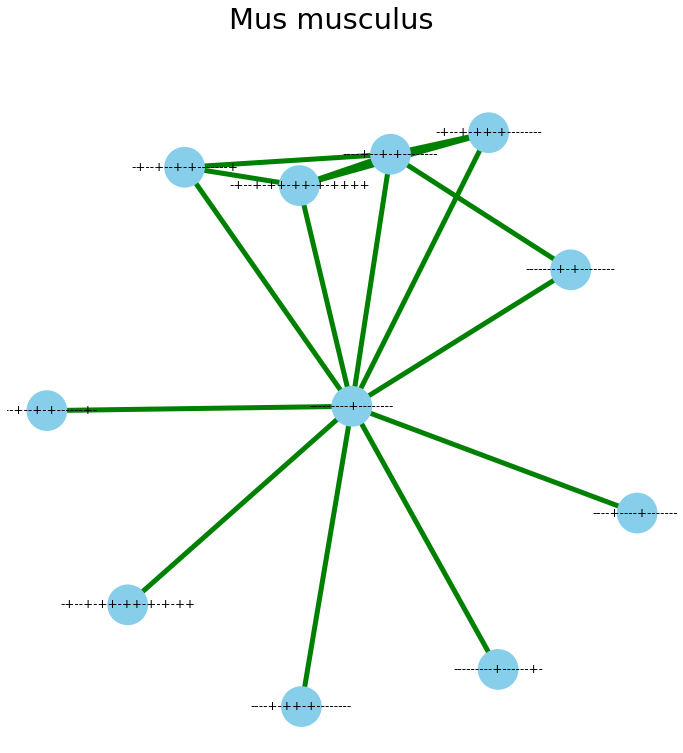

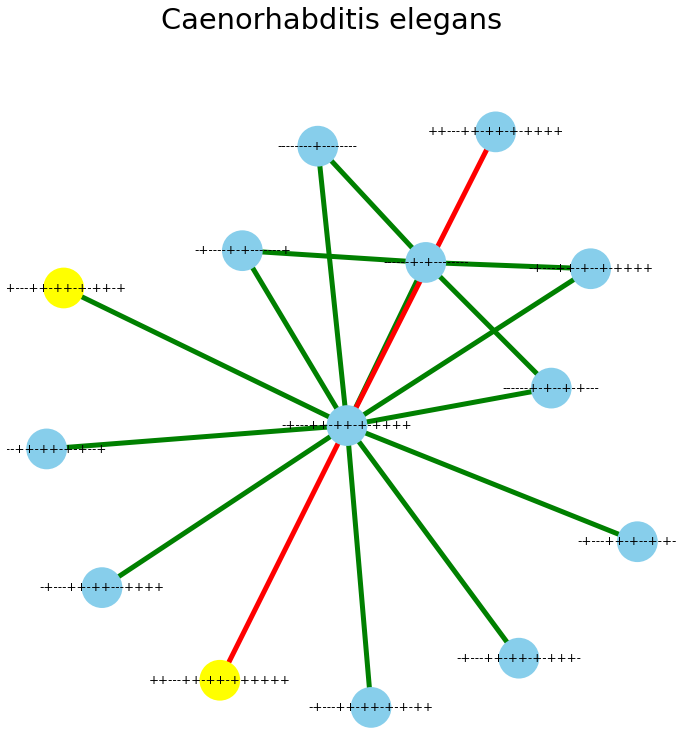

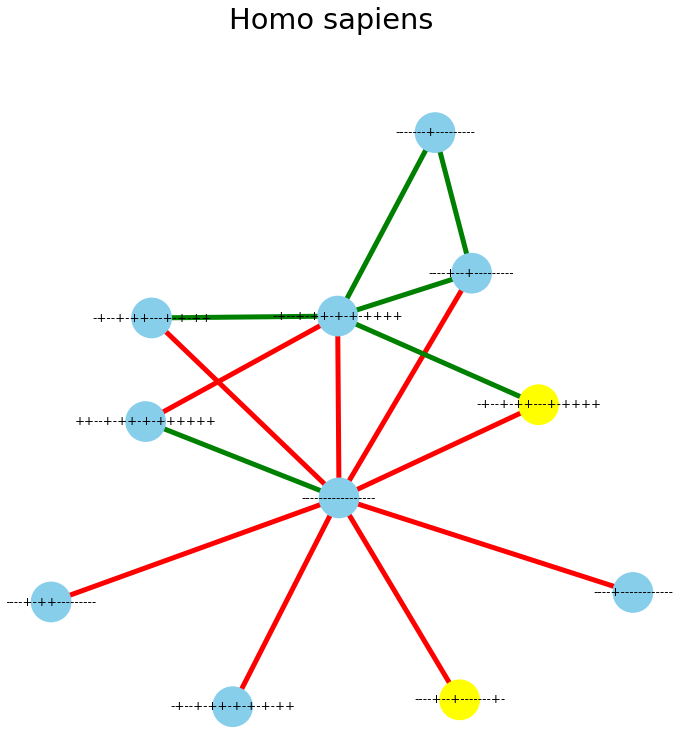

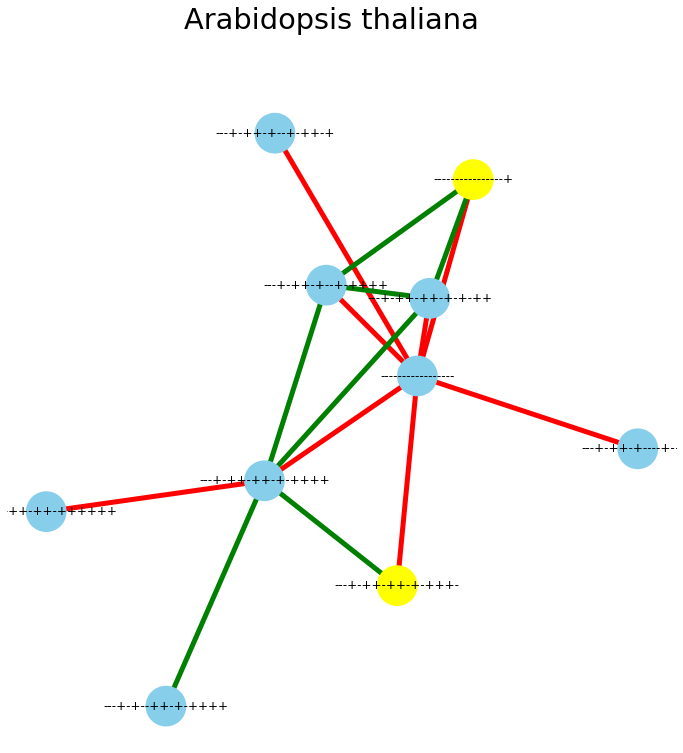

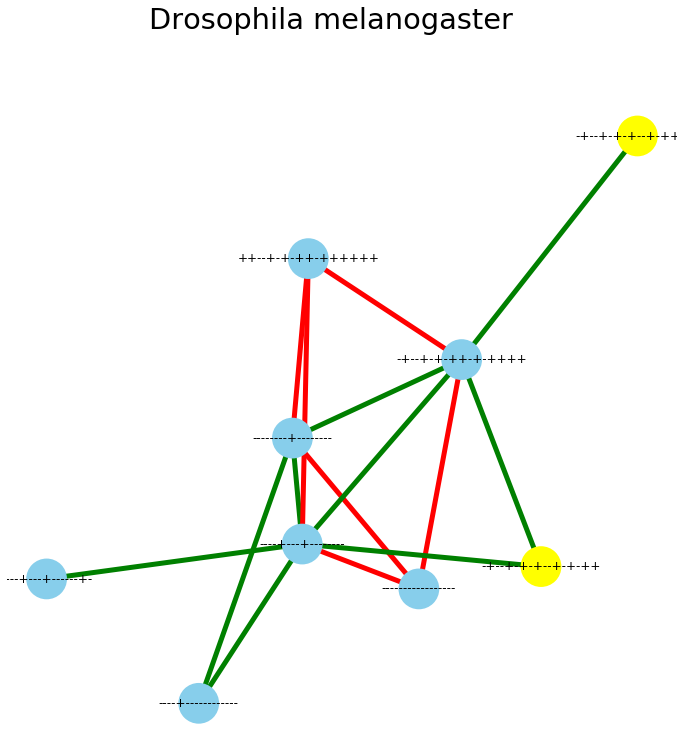

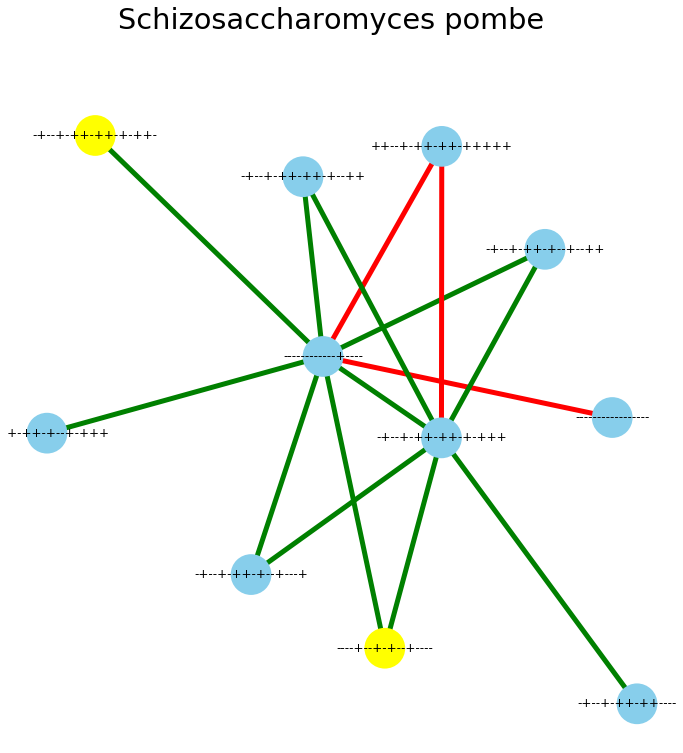

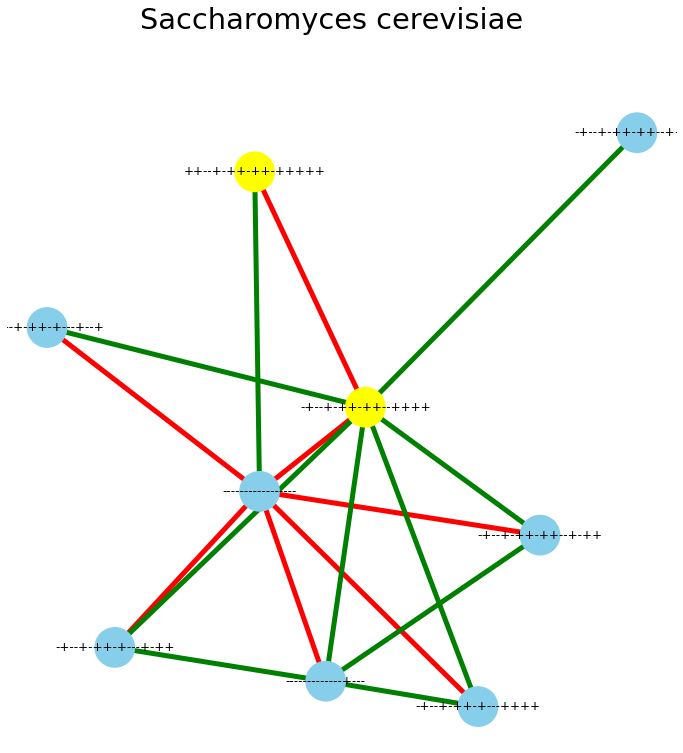

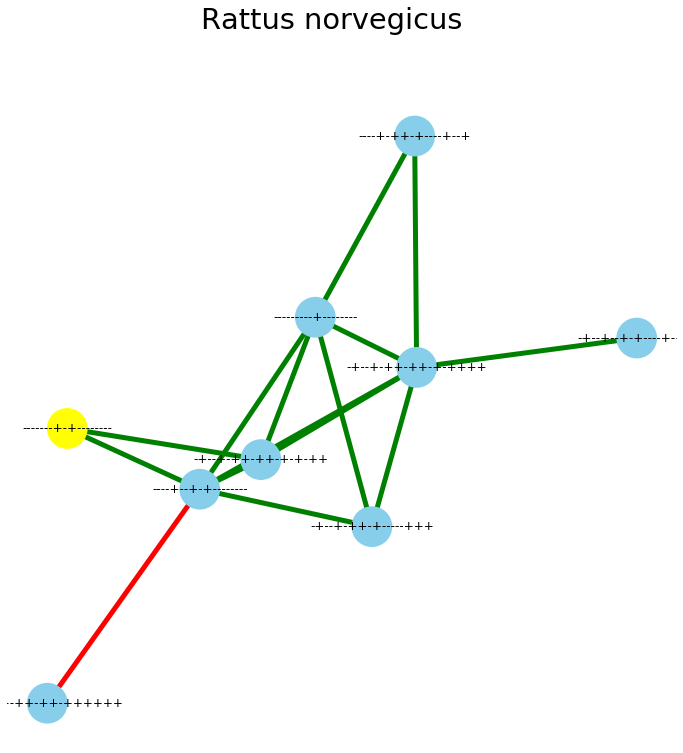

In [760]:
for k, v in PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations.items():
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    plt.suptitle(k)
    G = nx.from_pandas_edgelist(
        v[(v['p-value'] < 0.01)],
        prwlr.Columns.PROF_Q,
        prwlr.Columns.PROF_A,
        True,
        create_using=nx.Graph(),
    )
    edges_taxonomy = set([
        (p1, attr['taxonomy_Q'],)
        for p1, p2, attr in G.edges(data=True)
    ] + [
        (p2, attr['taxonomy_A'],)
        for p1, p2, attr in G.edges(data=True)
    ])
    edge_colors = [
        'green' if i[2]['taxonomy_common']
        else 'red'
        for i in G.edges(data=True)
    ]
    node_colors = []
    for p, t in edges_taxonomy:
        if t == 'eukar':
            node_colors.append('skyblue')
        elif t == 'bact':
            node_colors.append('red')
        elif t == 'arch':
            node_colors.append('green')
        else:
            node_colors.append('yellow')
    nx.draw(
        G,
        with_labels=True,
        node_size=1500,
        width=5,
        edge_color=edge_colors,
        node_color=node_colors,
        ax=axes,
    )

In [974]:
_df = PHYS_native_permuted_prof_str_p_vals_tabular_view_annotations['Saccharomyces cerevisiae']

In [980]:
_df

,PROF_Q,PROF_A,native_higher,native_lower,per_number,p-value,taxonomy_Q,taxonomy_A,taxonomy_common
0,-----------------,-----------------,False,True,787,0.213,mixed,mixed,True
1,-----------------,-----------------,True,False,213,0.787,mixed,mixed,True
2,-----------------,-------------+---,True,False,1000,0.000,mixed,eukar,False
3,-----------------,-+--+-++-+---+--+,True,False,1000,0.000,mixed,eukar,False
4,-----------------,-+--+-++-+---+-++,True,False,1000,0.000,mixed,eukar,False
5,-----------------,-+--+-++-+---++++,True,False,1000,0.000,mixed,eukar,False
6,-----------------,-+--+-++-++--+-++,True,False,1000,0.000,mixed,eukar,False
7,-----------------,-+--+-++-++--++++,True,False,1000,0.000,mixed,eukar,False
8,-----------------,++--+-++-++-+++++,True,False,1000,0.000,mixed,mixed,True
9,-------------+---,-------------+---,False,True,1,0.999,eukar,eukar,True


In [975]:
tuple(G.edges(data=True))[0]

('-----------------',
 '-----------------',
 {'native_higher': True,
  'native_lower': False,
  'per_number': 1000,
  'p-value': 0.0,
  'taxonomy_Q': 'mixed',
  'taxonomy_A': 'mixed',
  'taxonomy_common': True})

In [977]:
edges_significant

[('-----------------', '-------------+---'),
 ('-----------------', '-+--+-++-+---+--+'),
 ('-----------------', '-+--+-++-+---+-++'),
 ('-----------------', '-+--+-++-+---++++'),
 ('-----------------', '-+--+-++-++--+-++'),
 ('-----------------', '-+--+-++-++--++++'),
 ('-----------------', '++--+-++-++-+++++'),
 ('-------------+---', '-------------+---'),
 ('-------------+---', '-+--+-++-+---+-++'),
 ('-------------+---', '-+--+-++-+---++++'),
 ('-------------+---', '-+--+-++-++--+-++'),
 ('-------------+---', '-+--+-++-++--++++'),
 ('-+--+-++-+---+--+', '-+--+-++-++--++++'),
 ('-+--+-++-+---+-++', '-+--+-++-++--++++'),
 ('-+--+-++-+---++++', '-+--+-++-++--++++'),
 ('-+--+-++-++--+-++', '-+--+-++-++--++++'),
 ('-+--+-++-++--++++', '-+--+-++-++--+++-'),
 ('-+--+-++-++--++++', '-+--+-++-++--++++'),
 ('-+--+-++-++--++++', '++--+-++-++-+++++')]

In [979]:
edges_insignificant

[('-----------------', '-----------------')]

In [981]:
edges_insignificant = [(e1, e2, a,) for (e1, e2, a,) in G.edges(data=True) if a['p-value'] >= 0.01]

In [982]:
edges_insignificant

[('-----------------',
  '-----------------',
  {'native_higher': True,
   'native_lower': False,
   'per_number': 213,
   'p-value': 0.787,
   'taxonomy_Q': 'mixed',
   'taxonomy_A': 'mixed',
   'taxonomy_common': True})]

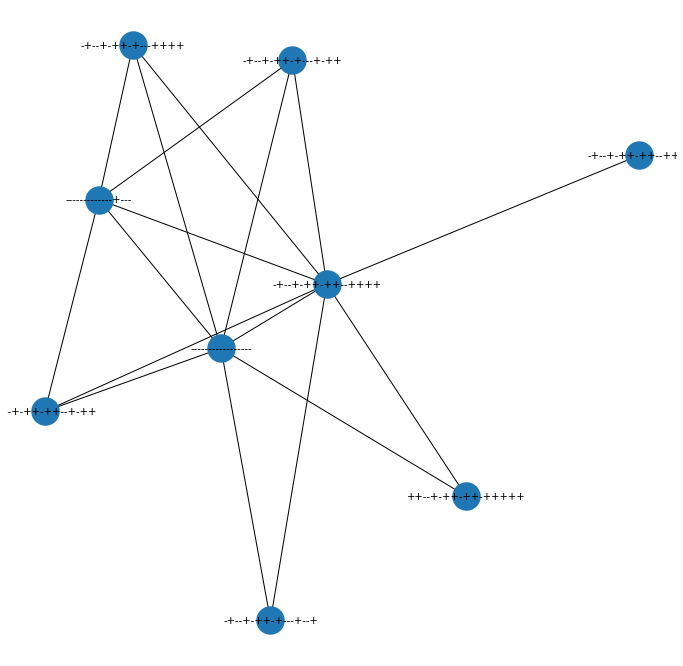

In [976]:
G = nx.from_pandas_edgelist(
    _df,
    prwlr.Columns.PROF_Q,
    prwlr.Columns.PROF_A,
    True,
    create_using=nx.Graph(),
)

edges_significant = [(e1, e2,) for (e1, e2, a) in G.edges(data=True) if a['p-value'] < 0.01]
edges_insignificant = [(e1, e2,) for (e1, e2, a,) in G.edges(data=True) if a['p-value'] >= 0.01]
edges_large = [(e1, e2) for (e1, e2, a) in G.edges(data=True) if a['per_number'] > 999]
edges_small = [(e1, e2) for (e1, e2, a) in G.edges(data=True) if a['per_number'] <= 999]

pos = nx.spring_layout(G)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=edges_significant, color='b')
nx.draw_networkx_edges(G, pos, edgelist=edges_insignificant, color='b', style='dashed')
# nx.draw_networkx_edges(G, pos, edgelist=edges_large, width=6)
# nx.draw_networkx_edges(G, pos, edgelist=edges_small, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()

In [850]:
PHYS_native_prof_str['Arabidopsis thaliana']['']

,PROF_Q,PROF_A,inter_sum,inter_number,inter_perc,INTERACTION
0,-----------------,-----------------,11548.0,1613.0,0.139678,-
1,-----------------,----------------+,11548.0,365.0,0.031607,-
2,-----------------,---------------++,11548.0,2.0,0.000173,-
3,-----------------,--------------+-+,11548.0,1.0,0.000087,-
4,-----------------,-------------+--+,11548.0,24.0,0.002078,-
...,...,...,...,...,...,...
2849,+++++++++++++++++,-++-+--+--+-----+,11548.0,1.0,0.000087,-
2850,+++++++++++++++++,-++-+-+++++---+++,11548.0,1.0,0.000087,-
2851,+++++++++++++++++,-+++-++++-++-+-++,11548.0,3.0,0.000260,-
2853,+++++++++++++++++,+--------+-++++-+,11548.0,1.0,0.000087,-


In [753]:
edges_taxonomy = set([
    (p1, attr['taxonomy_Q'],)
    for p1, p2, attr in G.edges(data=True)
] + [
    (p2, attr['taxonomy_A'],)
    for p1, p2, attr in G.edges(data=True)
])

In [754]:
edges_taxonomy

{('++--+-++-++-++++++', 'mixed'),
 ('-+--+-++-++-+-++++', 'eukar'),
 ('-+--+-++-++-+-+-++', 'eukar'),
 ('-+--+-++-+-----+++', 'eukar'),
 ('-+--+--+-+----+-++', 'eukar'),
 ('----+-++-+----+--+', 'eukar'),
 ('----+--+-+--------', 'eukar'),
 ('-------+-+--------', 'eukar'),
 ('---------+--------', 'eukar')}

In [ ]:
edges_color = [
    ''
    for p, c in edges_taxonomy
]

Inject the taxon identical to the network organism

In [657]:
PHYS_native_permuted_prof_str_aff_p_vals.keys()

dict_keys(['Mus musculus', 'Caenorhabditis elegans', 'Homo sapiens', 'Arabidopsis thaliana', 'Drosophila melanogaster', 'Schizosaccharomyces pombe', 'Saccharomyces cerevisiae', 'Rattus norvegicus'])

In [659]:
names_IDs

{'Agrobacterium fabrum': 'atu',
 'Bacillus subtilis': 'bsu',
 'Chlamydophila felis': 'cfe',
 'Escherichia coli': 'eco',
 'Staphylococcus aureus': 'sau',
 'Aeropyrum pernix': 'ape',
 'Sulfolobus islandicus': 'sis',
 'Arabidopsis thaliana': 'ath',
 'Caenorhabditis elegans': 'cel',
 'Dictyostelium discoideum': 'ddi',
 'Drosophila melanogaster': 'dme',
 'Homo sapiens': 'hsa',
 'Plasmodium falciparum': 'pfa',
 'Saccharomyces cerevisiae': 'sce',
 'Schizosaccharomyces pombe': 'spo',
 'Tetrahymena thermophila': 'tet',
 'Trypanosoma cruzi': 'tcr',
 'Volvox carteri': 'vcn'}

In [670]:
PHYS_native_permuted_prof_str_aff_p_vals_include_net_org = PHYS_native_permuted_prof_str_aff_p_vals.copy()

for k, v in PHYS_native_permuted_prof_str_aff_p_vals_include_net_org.items():
    if k in names_IDs.keys():
        v[f'{prwlr.Columns.PROF_Q}_included'] = v[prwlr.Columns.PROF_Q].apply(
            lambda x: prwlr.profiles.Profile(
                query=x.query + [names_IDs[k]],
                reference=x.reference,
            )
        )
        v[f'{prwlr.Columns.PROF_A}_included'] = v[prwlr.Columns.PROF_A].apply(
            lambda x: prwlr.profiles.Profile(
                query=x.query + [names_IDs[k]],
                reference=x.reference,
            )
        )
        v.drop(columns=[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A], inplace=True)
        v.rename(
            columns={
                f'{prwlr.Columns.PROF_Q}_included': prwlr.Columns.PROF_Q,
                f'{prwlr.Columns.PROF_A}_included': prwlr.Columns.PROF_A,
            },
            inplace=True,
        )

In [681]:
_df1 = tuple(PHYS_native_permuted_prof_str_aff_p_vals_include_net_org.values())[0]

In [682]:
_df2 = tuple(PHYS_native_permuted_prof_str_aff_p_vals_include_net_org.values())[1]

In [684]:
len(_df1[prwlr.Columns.PROF_Q][0])

18

In [685]:
len(_df2[prwlr.Columns.PROF_Q][0])

18

In [687]:
pd.merge(
    left=_df1,
    right=_df2,
    on=[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A]
)

,PROF_Q,PROF_A,native_higher_x,native_lower_x,per_number_x,p-value_x,native_higher_y,native_lower_y,per_number_y,p-value_y
0,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,False,False,11,0.989
1,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,False,True,8,0.992
2,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,True,False,981,0.019
3,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,False,False,210,0.790
4,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,False,True,152,0.848
5,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,True,False,638,0.362


In [698]:
len(PHYS_native_permuted_prof_str_aff_p_vals_include_net_org)

8

In [709]:
reduce(
    lambda df1, df2: pd.merge(
        left=df1,
        right=df2,
        on=[prwlr.Columns.PROF_Q, prwlr.Columns.PROF_A],
    ),
    tuple(PHYS_native_permuted_prof_str_aff_p_vals_include_net_org.values())[:3],
)

,PROF_Q,PROF_A,native_higher_x,native_lower_x,per_number_x,p-value_x,native_higher_y,native_lower_y,per_number_y,p-value_y,native_higher,native_lower,per_number,p-value
0,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,False,False,11,0.989,True,False,1000,0.0
1,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,False,True,8,0.992,True,False,1000,0.0
2,----+--+-+--------,----+--+-+--------,True,False,1000,0.0,True,False,981,0.019,True,False,1000,0.0
3,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,False,False,210,0.790,True,False,1000,0.0
4,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,False,True,152,0.848,True,False,1000,0.0
5,----+--+-+--------,-+--+-++-++-+-++++,True,False,1000,0.0,True,False,638,0.362,True,False,1000,0.0
